### Computational Machine Learning (COSC2673)
### Assignment 2 : Project 1 - Classify image of road traffic signs
#### Vishwa Gandhi (S3714805)

### Aim
The aim of this project is to train a model which can classify image of road traffic signs wih supervised image machine learning techniques. The major two tasks of this assignment are to classify images according to sign-shape and sign-type. This report has implementation and analysis of Neural Network and Deep Convolution Neural Network(CNN). Analysis is supported by evaluation and results. The data set used for training the model is a modified version of the Belgium Traffic Sign Classification Benchmark. Data has 28*28 grayscale images which are labled according to shape and type of the road traffic sign.

Code to extract files from the zipped dataset into jupyter directory.

In [ ]:
# Extracting files from the zipped dataset into directory

# import zipfile as zf
# files = zf.ZipFile("trafficsigns_dataset-1.zip", 'r')
# files.extractall('imgs')
# files.close()

# import zipfile as zf
# files = zf.ZipFile("EvaluationData.zip", 'r')
# files.extractall('EvalData')
# files.close()

Following section will load all the packages required to perfrom analysis in this project.

In [68]:
# Command to install tensorflow
# !conda install --yes tensorflow

# Import packages required to perform the analysis
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.preprocessing import image

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

tf.__version__

'1.13.1'

### Data Preparation

Data is loaded in the Pandas DataFrame from the directory in which all the files are stored. Traffic sign type and shape unique labels are added to the dataset to generate catagorical values for feeding into model. 'Shape' has 5 different values and 'Signtype' has total 16 unique classes.

In [4]:
# Reading image data from the path
image_list = []

for filepath in glob.glob('./imgs/trafficsigns_dataset/*/*/*.png', recursive=True): #assuming gif
    signtype = filepath.split("\\")[-2]
    shape = filepath.split("\\")[-3]
    image_list.append((filepath, signtype, shape))
    
# Create a data frame
traffic_data = pd.DataFrame(data=image_list, columns=['image_path', 'signtype', 'shape'])

# Adding lable numbers for sign shape and type
mapshape = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
maptype = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5,
           'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10,
           'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

# Mapping lables to shape and type
traffic_data['shape_labels_num'] = traffic_data['shape'].map(mapshape, na_action='ignore')
traffic_data['type_labels_num'] = traffic_data['signtype'].map(maptype, na_action='ignore')

# Checking loaded data
traffic_data.head()

,image_path,signtype,shape,shape_labels_num,type_labels_num
0,./imgs/trafficsigns_dataset\diamond\rightofway...,rightofway,diamond,0,0
1,./imgs/trafficsigns_dataset\diamond\rightofway...,rightofway,diamond,0,0
2,./imgs/trafficsigns_dataset\diamond\rightofway...,rightofway,diamond,0,0
3,./imgs/trafficsigns_dataset\diamond\rightofway...,rightofway,diamond,0,0
4,./imgs/trafficsigns_dataset\diamond\rightofway...,rightofway,diamond,0,0


Now, let's load some of the images to confirm the data.

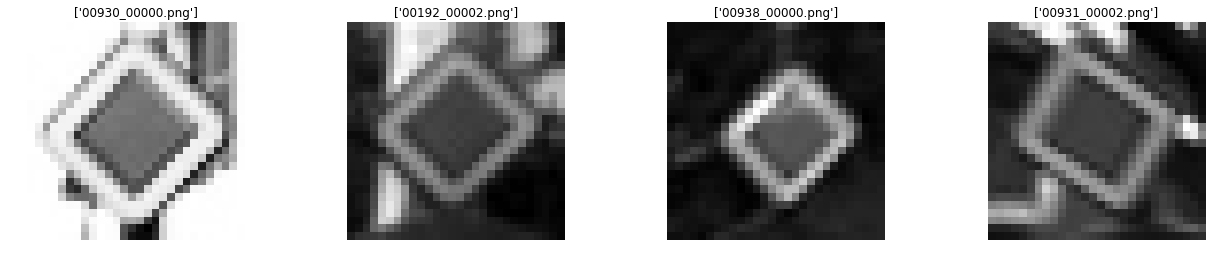

In [17]:
# ploting sample images from dataset
r_inx = np.random.choice(100, 4)
rand_data = traffic_data.loc[r_inx,'image_path']

plt.figure(figsize=(22,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    plt.title(label= image_path.split("\\")[3:])
    
plt.show();

In the following section, data variables are created to perform various operations on. Please note that, this section will create data for both shape analysis and type analysis.

Train_test split is performed on the original dataset to prepare it for using in model and hyperparameter tuning. This is very essential step for evaluating model performance. Original data is splitted in 80:20 train:test split. From which, training data is further splitted in 80:20 train:validation split. So for all the models in this analysis, we will use the data with following sizes:
Training: 2763, Validation: 592, Test: 740. This data will be used for train and testing the models.

To make sure that traing and testing data created by split should have specific shape & type data classes in equal proportion as original dataset, 'stratify' parameter is used. This will reduce the impact of imbalanced dataset.

Also, images are stored in np.array to perform Hyper parameter tuning with KerasClassifier to match the input format. Inorder to classify shape and type, catagorical variable of these featheres is also required. Here, to_categorical() is used to perform this operation.

In [113]:
# Preparing data for hyper parameter tuning
image_list_shape_trainval = []
image_list_type_trainval = []
image_list_shape_test = []
image_list_type_test = []

# Preparing data for imagegenerator and model building
train_df_shape, test_df_shape = train_test_split(traffic_data, test_size= 0.2, stratify = traffic_data['shape'], random_state = 22)
train_df_shape, val_df_shape = train_test_split(train_df_shape, test_size= 0.2, stratify = train_df_shape['shape'], random_state = 22)

train_df_type, test_df_type = train_test_split(traffic_data, test_size= 0.2, stratify = traffic_data['signtype'], random_state = 22)
train_df_type, val_df_type = train_test_split(train_df_type, test_size= 0.2, stratify = train_df_type['signtype'], random_state = 22)

trainval_df_shape = pd.concat([train_df_shape, val_df_shape])
trainval_df_type = pd.concat([train_df_type, val_df_type])

# Data of feature(image_path) and target variables(lables of shape and type)
features_shape_trainval = trainval_df_shape.iloc[:,0]
target_shape_trainval = trainval_df_shape.iloc[:,3]
features_type_trainval = trainval_df_type.iloc[:,0]
target_type_trainval = trainval_df_type.iloc[:,4]

features_shape_test = test_df_shape.iloc[:,0]
target_shape_test = test_df_shape.iloc[:,3]
features_type_test = test_df_type.iloc[:,0]
target_type_test = test_df_type.iloc[:,4]

# Loading images into numpy array
def readImages(df):
    imlist= []
    for i in df:
        img = image.load_img(i, target_size=(28,28,1), grayscale=False)
        img = image.img_to_array(img)
        img = img/255
        imlist.append(img)    
    opval = np.array(imlist)
    return imlist, opval
 
image_list_shape_trainval, X_shape_trainval = readImages(features_shape_trainval)
image_list_type_trainval, X_type_trainval = readImages(features_type_trainval)
image_list_shape_test, X_shape_test = readImages(features_shape_test)
image_list_type_test, X_type_test = readImages(features_type_test)

# Coverting lables type to catagorical
cat_target_shape_trainval = tf.keras.utils.to_categorical(target_shape_trainval)
cat_target_type_trainval = tf.keras.utils.to_categorical(target_type_trainval)

cat_target_shape_test = tf.keras.utils.to_categorical(target_shape_test)
cat_target_type_test = tf.keras.utils.to_categorical(target_type_test)

N_train_images = train_df_shape.shape[0]
N_val_images = val_df_shape.shape[0]

shape_classes = traffic_data['shape'].nunique()
type_classes = traffic_data['signtype'].nunique()
print('Train shape:', train_df_shape.shape, ', Validation shape:', val_df_shape.shape, ', Test shape:',test_df_shape.shape)

Train shape: (2367, 5) , Validation shape: (592, 5) , Test shape: (740, 5)




Before fitting the model on raw images, some operations needs to be performed. ImageDataGenerator can be in this case to perform image transformations like rescaling, rotation, width/height shifts. One major purpose behind using ImageDataGenerator is to process the data in batches. This will avoid memory usage by only batchwise loading data into memory. This is an impactful approach while dealing with large datasets.

In [114]:
# Preparing image generator data for batch model fitting
CNN_aug_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
CNN_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
CNN_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_shape = 15
batch_size_type = 15
epoch_shape= 60
epoch_type = 60

CNN_aug_train_generator_shape = CNN_aug_train_datagen.flow_from_dataframe(
        dataframe=train_df_shape,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_shape,
        class_mode='categorical')

CNN_train_generator_shape = CNN_train_datagen.flow_from_dataframe(
        dataframe=train_df_shape,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_shape,
        class_mode='categorical')

CNN_validation_generator_shape = CNN_val_datagen.flow_from_dataframe(
        dataframe=val_df_shape,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_shape,
        class_mode='categorical')

CNN_test_generator_shape = CNN_val_datagen.flow_from_dataframe(
        dataframe=test_df_shape,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_shape,
        class_mode='categorical')


CNN_aug_train_generator_type = CNN_aug_train_datagen.flow_from_dataframe(
        dataframe=train_df_type,
        directory='./',
        x_col="image_path",
        y_col="signtype",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical')

CNN_train_generator_type = CNN_train_datagen.flow_from_dataframe(
        dataframe=train_df_type,
        directory='./',
        x_col="image_path",
        y_col="signtype",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical')

CNN_validation_generator_type = CNN_val_datagen.flow_from_dataframe(
        dataframe=val_df_type,
        directory='./',
        x_col="image_path",
        y_col="signtype",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical')

CNN_test_generator_type = CNN_val_datagen.flow_from_dataframe(
        dataframe=test_df_type,
        directory='./',
        x_col="image_path",
        y_col="signtype",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical',
        shuffle = False)


Found 2367 validated image filenames belonging to 5 classes.
Found 2367 validated image filenames belonging to 5 classes.
Found 592 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 2367 validated image filenames belonging to 16 classes.
Found 2367 validated image filenames belonging to 16 classes.
Found 592 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


### Data Distribution

Checking the data to understand the distribution will help in interpreting performance of the model for certain classes. Following sections shows distribution of each category of sign type and shape across entire dataset. It can be easily seen here that data is imbalanced for both the parameters. There are very few images available for shapes like hex and diamond as compared to round and triange. Likewise, image count for sign type like stop and crossing are very less in comparision to the warning and noentry type.

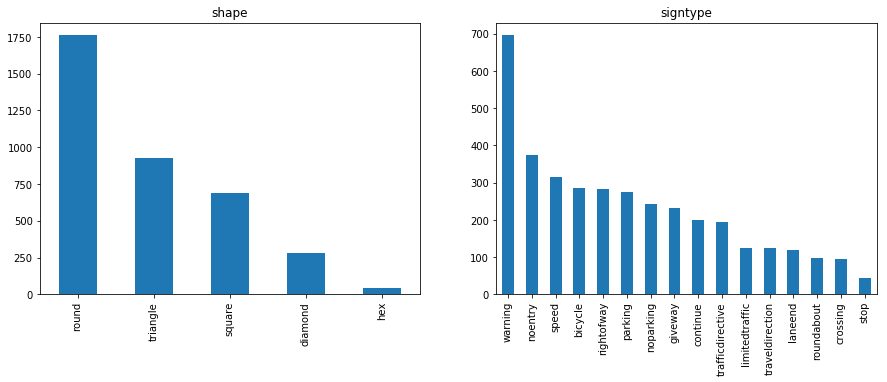

In [5]:
# traffic_data['shape'].value_counts().plot(kind='bar')
categorical_features = ["shape", "signtype"]
fig, ax = plt.subplots(1, len(categorical_features))
# fig = plt.figure(figsize=(10,20))
for i, categorical_feature in enumerate(traffic_data[categorical_features]):
    traffic_data[categorical_feature].value_counts().plot("bar", ax=ax[i], figsize = (15,5)).set_title(categorical_feature)
fig.show()

### Building General Functions

In order to increase the code reusabilty and readabilty some general functions are created.

Creating evaluation functions to calculate f1-score, precision and recall of models.

In [24]:
# Calculating extra matrixs for evaluation using these functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Function to fit model on the model passed in arguement with other specifications.

In [33]:
def model_fitting(model, batch_size, n_epochs, train_generator_data, validation_generator_data, no_train_images, no_val_images,
                   verbose=True):
    
    model_history = model.fit_generator(train_generator_data, validation_data = validation_generator_data, epochs = n_epochs,
                                       steps_per_epoch = no_train_images // batch_size, 
                                        validation_steps = no_val_images // batch_size)
    
    return model_history, model
 

Function to plot the loss and accuracy of the trained model.

In [138]:
def plot_results(history, epochs):
    plt.style.use('seaborn')
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r-')
    plt.plot(history.history['val_loss'],  'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0,np.max([5., np.max(history.history['loss']), np.max(history.history['val_loss'])])])
    plt.title('Loss Curves',fontsize=16, )
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'], 'r-')
    plt.plot(history.history['val_acc'], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0,np.max([1., np.max(history.history['acc']), np.max(history.history['val_acc'])])])
    
    plt.title('Accuracy Curves',fontsize=16, )
    plt.show();

# Sign-shape Analysis

## Neural Network

First model I have implemented is a simple neural network. After observing the performance of this simple NN, advanced analysis will be conducted on Convolutional Neural Network(CNN). According to majority of the researches, CNN is a best choice for image classification. Although, I am implementing NN model to see the difference between both.

### Building NN specific function

Function to create Neural network model with given number of output class in the outer layer. Here, I have used same model configuration for shape and type analysis. 

'softmax' activation is used at output layer which generate list of probabilities of all possible outcomes. It is a good option for multi-class classification. 'Sigmoid' activation is used at hidden layer.

'categorical_crossentropy' and 'categorical_accuracy' is used as our problem is a multiclass classification.

Input shape (28,28,3) is used as Image Data Generator automatically converts image into 3-channels.

This function is returning hidden lapyer to visualize the TSNE on the same.

There are two options to create models in 'Keras' package. It can be done by either Sequential or Functional API. Here I have used Functional API. But, I will use Sequential method of model for CNN.

In [43]:
# Function to create Neural Network Model
def create_model_nn(opclass):
    # Input layer
    input_ = Input(shape=(28, 28, 3)) 
    input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
    x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

    # Hidden layer
    h = Dense(64)(x)
    h = Activation('sigmoid')(h)

    # Output layer
    out_ = Dense(opclass)(h)
    out_ = Activation('softmax')(out_)

    # Define model
    model_nn = Model(inputs=input_, outputs=out_)

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_nn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy, 'accuracy',f1_m, precision_m, recall_m])

    model_nn.summary()
    # Creating a model for feature vizualization (will be explained later)
    hidden_features = Model(inputs=input_, outputs=h)
    return model_nn,hidden_features

Building functions for plotting TSNE plot of training and validation hidden layer.

In [66]:
def extract_hidden_features(model_, generator_, N_images, batch_sizen): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_sizen:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features


def plotTsne(inputs, y, features):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,2)
    features_embedded = TSNE(n_components=2).fit_transform(features)
    plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
    plt.title('Hidden Layer Embedding')

    plt.subplot(1,2,1)
    inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
    plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
    plt.title('Input Embedding')
    plt.show();

##### Sign type NN final model

Let's perfrom model fitting using data generated by ImageDataGenerator with 100 epochs. 

In [45]:
model_nn_shape, hf_nn_shape = create_model_nn(shape_classes)
# nn_shape_hist, op_nn_shape = model_fitting(model_nn_shape, batch_size_shape, n_epochs= 100,
                                    train_generator_data=CNN_train_generator_shape, 
                                    validation_generator_data=CNN_validation_generator_shape, no_train_images=N_train_images,
                                    no_val_images=N_val_images,  verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_71 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_72 (Activation)   (None, 5)                 0         
Total para

148/148 [==============================] - 2s 11ms/step - loss: 0.1515 - categorical_accuracy: 0.9594 - acc: 0.9594 - f1_m: 0.9599 - precision_m: 0.9685 - recall_m: 0.9518 - val_loss: 0.1913 - val_categorical_accuracy: 0.9426 - val_acc: 0.9426 - val_f1_m: 0.9423 - val_precision_m: 0.9548 - val_recall_m: 0.9307
Epoch 16/100
148/148 [==============================] - 3s 18ms/step - loss: 0.1450 - categorical_accuracy: 0.9607 - acc: 0.9607 - f1_m: 0.9577 - precision_m: 0.9679 - recall_m: 0.9483 - val_loss: 0.1789 - val_categorical_accuracy: 0.9493 - val_acc: 0.9493 - val_f1_m: 0.9472 - val_precision_m: 0.9619 - val_recall_m: 0.9341
Epoch 17/100
148/148 [==============================] - 3s 18ms/step - loss: 0.1367 - categorical_accuracy: 0.9675 - acc: 0.9675 - f1_m: 0.9667 - precision_m: 0.9736 - recall_m: 0.9603 - val_loss: 0.1712 - val_categorical_accuracy: 0.9527 - val_acc: 0.9527 - val_f1_m: 0.9543 - val_precision_m: 0.9652 - val_recall_m: 0.9443
Epoch 18/100
148/148 [================

Epoch 32/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0705 - categorical_accuracy: 0.9873 - acc: 0.9873 - f1_m: 0.9861 - precision_m: 0.9894 - recall_m: 0.9831 - val_loss: 0.1396 - val_categorical_accuracy: 0.9544 - val_acc: 0.9544 - val_f1_m: 0.9573 - val_precision_m: 0.9642 - val_recall_m: 0.9510
Epoch 33/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0639 - categorical_accuracy: 0.9882 - acc: 0.9882 - f1_m: 0.9874 - precision_m: 0.9902 - recall_m: 0.9848 - val_loss: 0.1373 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9572 - val_precision_m: 0.9640 - val_recall_m: 0.9510
Epoch 34/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0642 - categorical_accuracy: 0.9852 - acc: 0.9852 - f1_m: 0.9853 - precision_m: 0.9881 - recall_m: 0.9827 - val_loss: 0.1415 - val_categorical_accuracy: 0.9544 - val_acc: 0.9544 - val_f1_m: 0.9555 - val_precision_m: 0.9623 - val_recall_m: 0.9493
Epoch 35/100
148/148 [===

Epoch 49/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0387 - categorical_accuracy: 0.9958 - acc: 0.9958 - f1_m: 0.9955 - precision_m: 0.9970 - recall_m: 0.9941 - val_loss: 0.1220 - val_categorical_accuracy: 0.9628 - val_acc: 0.9628 - val_f1_m: 0.9641 - val_precision_m: 0.9711 - val_recall_m: 0.9578
Epoch 50/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0368 - categorical_accuracy: 0.9954 - acc: 0.9954 - f1_m: 0.9947 - precision_m: 0.9958 - recall_m: 0.9937 - val_loss: 0.1311 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9608 - val_precision_m: 0.9676 - val_recall_m: 0.9544
Epoch 51/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0363 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0.9960 - precision_m: 0.9966 - recall_m: 0.9954 - val_loss: 0.1256 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9625 - val_precision_m: 0.9677 - val_recall_m: 0.9578
Epoch 52/100
148/148 [===

Epoch 66/100
148/148 [==============================] - 3s 17ms/step - loss: 0.0243 - categorical_accuracy: 0.9970 - acc: 0.9970 - f1_m: 0.9966 - precision_m: 0.9975 - recall_m: 0.9958 - val_loss: 0.1267 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9600 - val_precision_m: 0.9660 - val_recall_m: 0.9544
Epoch 67/100
148/148 [==============================] - 2s 11ms/step - loss: 0.0235 - categorical_accuracy: 0.9970 - acc: 0.9970 - f1_m: 0.9970 - precision_m: 0.9975 - recall_m: 0.9966 - val_loss: 0.1400 - val_categorical_accuracy: 0.9443 - val_acc: 0.9443 - val_f1_m: 0.9456 - val_precision_m: 0.9507 - val_recall_m: 0.9409
Epoch 68/100
148/148 [==============================] - 2s 11ms/step - loss: 0.0232 - categorical_accuracy: 0.9979 - acc: 0.9979 - f1_m: 0.9975 - precision_m: 0.9979 - recall_m: 0.9970 - val_loss: 0.1267 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9602 - val_precision_m: 0.9628 - val_recall_m: 0.9578
Epoch 69/100
148/148 [===

Epoch 83/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0159 - categorical_accuracy: 0.9987 - acc: 0.9987 - f1_m: 0.9991 - precision_m: 0.9996 - recall_m: 0.9987 - val_loss: 0.1168 - val_categorical_accuracy: 0.9595 - val_acc: 0.9595 - val_f1_m: 0.9601 - val_precision_m: 0.9644 - val_recall_m: 0.9561
Epoch 84/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0160 - categorical_accuracy: 0.9987 - acc: 0.9987 - f1_m: 0.9985 - precision_m: 0.9992 - recall_m: 0.9979 - val_loss: 0.1197 - val_categorical_accuracy: 0.9595 - val_acc: 0.9595 - val_f1_m: 0.9602 - val_precision_m: 0.9627 - val_recall_m: 0.9578
Epoch 85/100
148/148 [==============================] - 2s 13ms/step - loss: 0.0154 - categorical_accuracy: 0.9992 - acc: 0.9992 - f1_m: 0.9996 - precision_m: 1.0000 - recall_m: 0.9992 - val_loss: 0.1183 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9617 - val_precision_m: 0.9678 - val_recall_m: 0.9561
Epoch 86/100
148/148 [===

148/148 [==============================] - 2s 16ms/step - loss: 0.0119 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.1260 - val_categorical_accuracy: 0.9595 - val_acc: 0.9595 - val_f1_m: 0.9601 - val_precision_m: 0.9644 - val_recall_m: 0.9561
Epoch 100/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0118 - categorical_accuracy: 0.9996 - acc: 0.9996 - f1_m: 0.9996 - precision_m: 0.9996 - recall_m: 0.9996 - val_loss: 0.1304 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9609 - val_precision_m: 0.9643 - val_recall_m: 0.9578


Visualization of the result of NN model for Shape classification shows model performance. Loss Curves and Accuracy curves can be studied to learn the model performance over all epochs.

Here, Training model shows better performance in terms of both loss and curves. This can be a result of model overfitting. Techinques like drop out, regularization penulty can be applied to the model to reduce model overfitting. I have not performed that here as I have selected CNN as my advanced model/

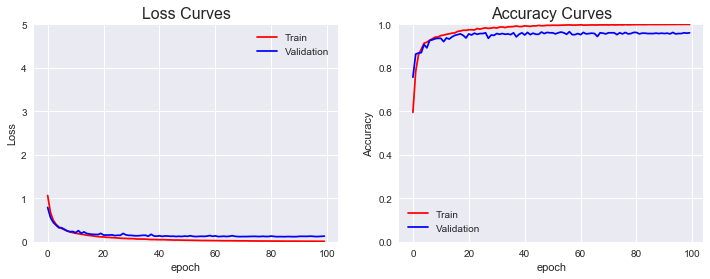

In [143]:
plot_results(history=nn_shape_hist, epochs=100)

In [92]:
# calConfusionMatrix(op_nn_shape , X_shape_test, target_shape_test, target_names_shape)

#### Extract and visualize the hidden layer feature of NN 

Output from desired hidden layers for training is are extracted in this section. This is a TSNE plot. Hidden layer embedding conveys how tightly clustered training data classes are in hidden layer. Similarly, input and hidden layer embedding for validation data is plotted.

Close observation gives a key insight that hidden layer of training output has tighter cluster than of validation output. This evidently supports the overfitting behavior of training model.

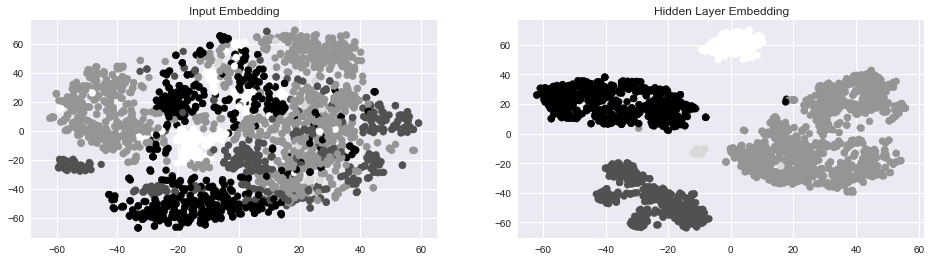

In [69]:
inputs_shape_train, y_shape_train, features_shape_train = extract_hidden_features(hf_nn_shape,
                                        CNN_train_generator_shape, N_train_images, batch_size_shape)

plotTsne(inputs_shape_train, y_shape_train, features_shape_train)

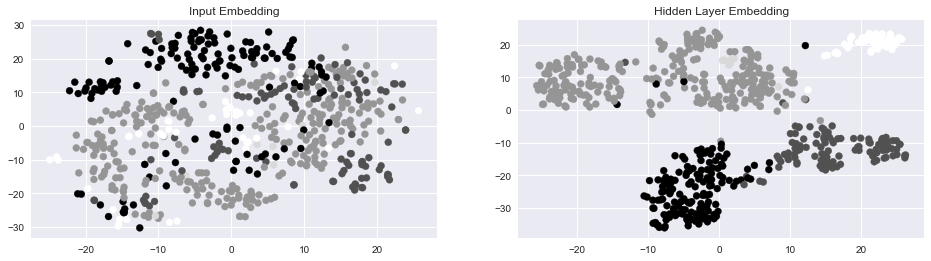

In [70]:
inputs_shape_test, y_shape_test, features_shape_test = extract_hidden_features(hf_nn_shape,
                                        CNN_validation_generator_shape, N_val_images, batch_size_shape)

plotTsne(inputs_shape_test, y_shape_test, features_shape_test)

In [ ]:
inputs, y, features = extract_hidden_features(hidden_features, validation_generator, N_val_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

### Deep CNN Network

I have selected Deep CNN Network for my advanced analysis. CNN is most widely used image classification algorithm in supervised learning.

Building functions for creating deep CNN network. I have already mentioned the choices I made for input sieze and activation function. Here, i have l2 regularization. It is reducing the impact of bias in input data. Value for l2 is set by manually experimenting parameter with values (0.001,0.01, 0.05).

Optimizer used is Stochastic Gradient Descent called 'SGD'.  SGD implements minima which prevents from the local minima. It tries to find more flatter minima. There are other optimizers like 'Adam' and 'RMSProp'. There is some trade off in using other optimzers. For example, ADAM quickly converges towards sharper minima which is less desirable. But the ability to deal with local minima is the key element which made me choose SGD over other otimizers. 

In [105]:
def cnn_create_model(output_class, learning_rate = 0.01, momentum_param = 0.9, n1= 32, n2=32, n3=64, n4= 64, reg = 0.001):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(n1, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    model_cnn.add(Conv2D(n2, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    model_cnn.add(Conv2D(n3, (3, 3)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_cnn.add(Dense(n4))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(output_class))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum= momentum_param, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy, 'accuracy',f1_m, precision_m, recall_m])

    model_cnn.summary()
    return model_cnn

Function for calculating and plotting confusion matrix and classification report. This project is a classification problem. So classification report is a good measure to analyze evaluation metrices like precision, recall and f1-score. Catagory wise values for these metrices is used for in-depth result analysis.

In [130]:
#Confution Matrix and Classification Report
target_names_shape = ['diamond', 'hex', 'round', 'square', 'triangle']
target_names_type = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking',
           'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue',
           'crossing', 'laneend', 'parking', 'giveway', 'warning']

def calConfusionMatrix(model_name ,test_data, test_lable, target_names):
    y_pred = model_name.predict_classes(test_data)
    print('Confusion Matrix')
    cfm= confusion_matrix(test_lable, y_pred)
    print(cfm)
    print('Classification Report')
    print(classification_report(test_lable, y_pred, target_names=target_names))
    plt.imshow(cfm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix of test data')
    plt.colorbar()
    plt.show()

def plotCm(cmr):
    plt.imshow(cmr, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix of test data')
    plt.colorbar()
    plt.show()




In [74]:
# summarize results
def summaryHyperParam(result_grid):
    print("Best: %f using %s" % (result_grid.best_score_, result_grid.best_params_))
    means = result_grid.cv_results_['mean_test_score']
    stds = result_grid.cv_results_['std_test_score']
    params = result_grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

### Hyper Parameter Tuning for Sign shape

Hyper parameter tuning is a method of identifying best performing set of paramater to fit the model on. KerasClassifier along with RandomizedSearchCV is ussed here. 2 fold cross validation is also being performed  to achieve best data with less overfitting effect. 

For Shape hyper parameter tuning I have performed it in two chunks. In first chunk, only CNN model nodes and epochs are tuned. In the second chunk, lerning rate and momentum of SGD optimizer are tuned.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# training neural network without param tuning ( yet to be added here)

import time
t0= time.time()

# create model
hyper_shape_model_1 = KerasClassifier(build_fn=cnn_create_model, verbose=True)

# define the grid search parameters
learn_rate = [0.001]
momentum = [0.9]
batch_size_list = [15]
epochs_n = [100,150]
opclass = [5]
n1= [16, 32, 64]
n2= [16, 32, 64]
n3= [32, 64]
n4= [32, 64]

# param_grid = dict(batch_size=batch_size_list, epochs = epochs_n, output_class = opclass, learning_rate=learn_rate,
#                   momentum_param=momentum, n1 =n1, n2=n2,n3=n3,n4=n4)
# grid1 = RandomizedSearchCV(estimator=hyper_shape_model_1 , param_distributions=param_grid, n_jobs=1, n_iter= 5, cv=2)
# grid_result1 = grid1.fit(X_shape_trainval , cat_target_shape_trainval)

t1 = time.time()
print("Time elapsed: ", str(t1 - t0) )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_10 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_11 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 32)          18464     
__________

1479/1479 [==============================] - 6s 4ms/sample - loss: 0.2880 - categorical_accuracy: 0.9337 - acc: 0.9337 - f1_m: 0.9319 - precision_m: 0.9495 - recall_m: 0.91580s - loss: 0.2799 - categorical_accuracy: 0.9358 - acc: 0.9358 - f1_m: 0.9357 - precis
Epoch 27/150
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.2885 - categorical_accuracy: 0.9304 - acc: 0.9304 - f1_m: 0.9278 - precision_m: 0.9467 - recall_m: 0.91114s - loss: 0.3254 - categorical_accuracy: 0.9289 - acc: 0.9289 - f1_m: 0.9229 - precision_m: 0.9409 - recall_m:  - ETA: 4s - loss: 0.3104 - categorical_accuracy: 0.9296 - acc: 0.9296 - f1_m: 0.9263 - precision_m: 0.9431 - recall_m - ETA: 4s - loss: 0.3085 - categorical_accuracy: 0.9303 - acc: 0.9303 - f1_m: 0.9288 - precisio - ETA: 3s - loss: 0.2875 
Epoch 28/150
1479/1479 [==============================] - 5s 4ms/sample - loss: 0.2610 - categorical_accuracy: 0.9446 - acc: 0.9446 - f1_m: 0.9380 - precision_m: 0.9499 - recall_m: 0.9273
Epoch 29/15

1479/1479 [==============================] - 5s 3ms/sample - loss: 0.1318 - categorical_accuracy: 0.9811 - acc: 0.9811 - f1_m: 0.9806 - precision_m: 0.9844 - recall_m: 0.9771
Epoch 64/150
1479/1479 [==============================] - 5s 3ms/sample - loss: 0.1217 - categorical_accuracy: 0.9844 - acc: 0.9844 - f1_m: 0.9848 - precision_m: 0.9910 - recall_m: 0.97910s - loss: 0.1225 - categorical_accuracy: 0.9844 - acc: 0.9844 - f1_m: 0.9840 - pr
Epoch 65/150
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.1283 - categorical_accuracy: 0.9844 - acc: 0.9844 - f1_m: 0.9833 - precision_m: 0.9861 - recall_m: 0.98070s - loss: 0.1280 - categorical_accuracy: 0.9850 - acc: 0.9850 - f1_m: 0.9843 - precision_m: 0.9871 - recall_m: 0.98
Epoch 66/150
1479/1479 [==============================] - 5s 3ms/sample - loss: 0.1184 - categorical_accuracy: 0.9878 - acc: 0.9878 - f1_m: 0.9854 - precision_m: 0.9885 - recall_m: 0.9825
Epoch 67/150
1479/1479 [==============================] - 5s 3m

1479/1479 [==============================] - 5s 3ms/sample - loss: 0.0979 - categorical_accuracy: 0.9878 - acc: 0.9878 - f1_m: 0.9881 - precision_m: 0.9906 - recall_m: 0.98590s - loss: 0.0989 - categorical_accuracy: 0.9873 - acc: 0.9873 - f1_m: 0.9868 - precision_m: 0.9890  - ETA: 0s - loss: 0.1004 - categorical_accuracy: 0.9864 - acc: 0.9864 - f1_m: 0.9866 - precision_m: 0.989
Epoch 97/150
1479/1479 [==============================] - 5s 3ms/sample - loss: 0.0897 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9942 - precision_m: 0.9959 - recall_m: 0.9926
Epoch 98/150
1479/1479 [==============================] - 5s 3ms/sample - loss: 0.0975 - categorical_accuracy: 0.9899 - acc: 0.9899 - f1_m: 0.9905 - precision_m: 0.9925 - recall_m: 0.9886
Epoch 99/150
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.0898 - categorical_accuracy: 0.9946 - acc: 0.9946 - f1_m: 0.9938 - precision_m: 0.9955 - recall_m: 0.9921
Epoch 100/150
1479/1479 [==============================

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0763 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9970 - precision_m: 0.9973 - recall_m: 0.99660s - loss: 0.0760 - categorical_accuracy: 0.9971 - acc: 0.9971 - f1_m: 0.9974 - precision_m: 0.9978 - recall_m: 
Epoch 132/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0764 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9946 - precision_m: 0.9953 - recall_m: 0.9939
Epoch 133/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0734 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9956 - precision_m: 0.9960 - recall_m: 0.9953
Epoch 134/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0747 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9963 - precision_m: 0.9973 - recall_m: 0.99533s - loss: 0.0724 - categorical_
Epoch 135/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0725 - categorical_accuracy: 0.

1480/1480 [==============================] - 5s 3ms/sample - loss: 1.0685 - categorical_accuracy: 0.6493 - acc: 0.6493 - f1_m: 0.5093 - precision_m: 0.7647 - recall_m: 0.39530s - loss: 1.0879 - categorical_accuracy: 0.6433 - acc: 0.6433 - f1_m: 0.4944 - precision_m: 0.751
Epoch 7/150
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.9694 - categorical_accuracy: 0.6905 - acc: 0.6905 - f1_m: 0.6069 - precision_m: 0.7845 - recall_m: 0.5024
Epoch 8/150
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.8615 - categorical_accuracy: 0.7284 - acc: 0.7284 - f1_m: 0.6839 - precision_m: 0.8170 - recall_m: 0.5949
Epoch 9/150
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.7914 - categorical_accuracy: 0.7669 - acc: 0.7669 - f1_m: 0.7381 - precision_m: 0.8394 - recall_m: 0.66402s - loss: 0.8367 - categorical_accuracy: 0.7542 - acc: 0.75
Epoch 10/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.6898 - categorical_accur

1480/1480 [==============================] - 6s 4ms/sample - loss: 0.1668 - categorical_accuracy: 0.9730 - acc: 0.9730 - f1_m: 0.9726 - precision_m: 0.9808 - recall_m: 0.96503s - loss: 0.1634 - categorical_accuracy: 0.9764 - acc: 0.9764 - f1_m: 0.9729 - precision_ - ETA: 2s - loss: 0.1649 - categorical_accuracy: 0.9731 - acc: 0.9731 - f1_m: 0.9709 - precision_m: 0 - ETA: 1s - loss: 0.1647 - categorical_accuracy: 0.9730 - acc: 0.9730 - f1_
Epoch 43/150
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.1623 - categorical_accuracy: 0.9716 - acc: 0.9716 - f1_m: 0.9709 - precision_m: 0.9788 - recall_m: 0.9636
Epoch 44/150
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.1450 - categorical_accuracy: 0.9750 - acc: 0.9750 - f1_m: 0.9772 - precision_m: 0.9838 - recall_m: 0.97105s - loss: 0.1566 - categorical_accuracy: 0.9600 - acc: 0.9600 - f1_m: 0.9664 - precisio - ETA: 4s - loss: 0.1467 - categorical_accuracy: 0.9733 - acc: 0.9733 - - ETA: 3s - loss: 0.1

1480/1480 [==============================] - 5s 3ms/sample - loss: 0.1179 - categorical_accuracy: 0.9838 - acc: 0.9838 - f1_m: 0.9838 - precision_m: 0.9877 - recall_m: 0.9805
Epoch 67/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.1116 - categorical_accuracy: 0.9872 - acc: 0.9872 - f1_m: 0.9860 - precision_m: 0.9901 - recall_m: 0.9822
Epoch 68/150
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.1080 - categorical_accuracy: 0.9899 - acc: 0.9899 - f1_m: 0.9908 - precision_m: 0.9939 - recall_m: 0.98793s - loss: 0.1073 - categorical_accuracy: 0.9889 - acc: 0.9889 - f1_m: 0.9888 - precision_ - ETA: 3s - loss: 0.1035 - categorical_accura - ETA: 1s - loss: 0.1081 - categorical_accuracy: 0.9897 - acc: 0.9897 - f1_m: 0.9909 
Epoch 69/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.1050 - categorical_accuracy: 0.9919 - acc: 0.9919 - f1_m: 0.9914 - precision_m: 0.9931 - recall_m: 0.9899
Epoch 70/150
1480/1480 [===============

1480/1480 [==============================] - 5s 3ms/sample - loss: 0.0917 - categorical_accuracy: 0.9912 - acc: 0.9912 - f1_m: 0.9918 - precision_m: 0.9946 - recall_m: 0.9892
Epoch 95/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.0832 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9976 - precision_m: 0.9980 - recall_m: 0.99731s - loss: 0.0846 - categorical_accuracy: 0.9969 - acc: 0.9969 - f1_m: 0.9
Epoch 96/150
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0868 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9938 - precision_m: 0.9966 - recall_m: 0.99123s - loss: 0.0907 - categorical_accuracy:  - ETA: 0s - loss: 0.0881 - categorical_accuracy: 0.9928 - acc: 0.9928 - f1_m: 0.9934 - precision_m: 0.9964 - recall_m
Epoch 97/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.0874 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9936 - precision_m: 0.9946 - recall_m: 0.9926
Epoch 98/150
1480/1480 [===

1480/1480 [==============================] - 5s 4ms/sample - loss: 0.0800 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9959 - precision_m: 0.9980 - recall_m: 0.99393s - loss: 0.0763 - categorical_accuracy: 0.9983 - acc: 0.9983 - f1_m: 0.9965 - precision_m: 0.9983 - recall_m:  - ETA: 3s - loss: 0.0766 - categorical_accuracy: 0.9984 - acc: 0.9984 - f1_m: 0.9968 - precision_m: 0.9984 - recall_m: 0. - ETA: 3s - loss: 0.0760 - categorical_accuracy: 0.9985 - acc: 0.9985 - f1_m: 0.9970 - precision_m: 0.9985  - ETA: 2s - loss: 0.0773 - categorical_accuracy: 0.9977 - acc: 0.9977 - f1_
Epoch 122/150
1480/1480 [==============================] - 5s 3ms/sample - loss: 0.0789 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9952 - precision_m: 0.9966 - recall_m: 0.9939
Epoch 123/150
1480/1480 [==============================] - 5s 4ms/sample - loss: 0.0734 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9983 - precision_m: 0.9987 - recall_m: 0.99801s - loss: 0.0725 - categorica

Epoch 1/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 1.5331 - categorical_accuracy: 0.3746 - acc: 0.3746 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+002s - loss: 1.5882 - categorical_accuracy: 0.3242 - acc: 0.3242 - f1_m: 0.0000e+00 
Epoch 2/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.3779 - categorical_accuracy: 0.4442 - acc: 0.4442 - f1_m: 0.0907 - precision_m: 0.3369 - recall_m: 0.0543
Epoch 3/100
1479/1479 [==============================] - 4s 2ms/sample - loss: 1.3253 - categorical_accuracy: 0.4638 - acc: 0.4638 - f1_m: 0.1608 - precision_m: 0.4596 - recall_m: 0.1017
Epoch 4/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2966 - categorical_accuracy: 0.4848 - acc: 0.4848 - f1_m: 0.1583 - precision_m: 0.4805 - recall_m: 0.0994
Epoch 5/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2458 - categorical_accuracy: 0.5112 - acc: 0.5112 - f1_m: 0.2182 - precision_

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.1279 - categorical_accuracy: 0.9743 - acc: 0.9743 - f1_m: 0.9726 - precision_m: 0.9791 - recall_m: 0.9666
Epoch 45/100
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.1184 - categorical_accuracy: 0.9770 - acc: 0.9770 - f1_m: 0.9761 - precision_m: 0.9806 - recall_m: 0.9719
Epoch 46/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1231 - categorical_accuracy: 0.9743 - acc: 0.9743 - f1_m: 0.9746 - precision_m: 0.9811 - recall_m: 0.9686
Epoch 47/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1094 - categorical_accuracy: 0.9790 - acc: 0.9790 - f1_m: 0.9802 - precision_m: 0.9850 - recall_m: 0.9758
Epoch 48/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1206 - categorical_accuracy: 0.9763 - acc: 0.9763 - f1_m: 0.9767 - precision_m: 0.9836 - recall_m: 0.9704
Epoch 49/100
1479/1479 [==============================] - 3s 2ms/sample -

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0616 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9966 - precision_m: 0.9980 - recall_m: 0.9953
Epoch 88/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0622 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9935 - precision_m: 0.9953 - recall_m: 0.9919
Epoch 89/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0530 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9976 - precision_m: 0.9980 - recall_m: 0.9973
Epoch 90/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0744 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9901 - precision_m: 0.9926 - recall_m: 0.9879
Epoch 91/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0620 - categorical_accuracy: 0.9926 - acc: 0.9926 - f1_m: 0.9929 - precision_m: 0.9939 - recall_m: 0.9919
Epoch 92/100
1479/1479 [==============================] - 4s 3ms/sample -

1480/1480 [==============================] - 4s 3ms/sample - loss: 0.4566 - categorical_accuracy: 0.8730 - acc: 0.8730 - f1_m: 0.8674 - precision_m: 0.9009 - recall_m: 0.8387
Epoch 15/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.4350 - categorical_accuracy: 0.8784 - acc: 0.8784 - f1_m: 0.8690 - precision_m: 0.9071 - recall_m: 0.8367
Epoch 16/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4028 - categorical_accuracy: 0.8851 - acc: 0.8851 - f1_m: 0.8825 - precision_m: 0.9166 - recall_m: 0.8539
Epoch 17/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4035 - categorical_accuracy: 0.8899 - acc: 0.8899 - f1_m: 0.8820 - precision_m: 0.9126 - recall_m: 0.8559
Epoch 18/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3524 - categorical_accuracy: 0.9115 - acc: 0.9115 - f1_m: 0.9020 - precision_m: 0.9359 - recall_m: 0.8731
Epoch 19/100
1480/1480 [==============================] - 4s 3ms/sample -

1480/1480 [==============================] - 4s 2ms/sample - loss: 0.0952 - categorical_accuracy: 0.9858 - acc: 0.9858 - f1_m: 0.9843 - precision_m: 0.9885 - recall_m: 0.9805
Epoch 55/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0977 - categorical_accuracy: 0.9818 - acc: 0.9818 - f1_m: 0.9806 - precision_m: 0.9846 - recall_m: 0.9768
Epoch 56/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1009 - categorical_accuracy: 0.9811 - acc: 0.9811 - f1_m: 0.9803 - precision_m: 0.9841 - recall_m: 0.9768
Epoch 57/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0943 - categorical_accuracy: 0.9838 - acc: 0.9838 - f1_m: 0.9837 - precision_m: 0.9871 - recall_m: 0.9805
Epoch 58/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0954 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9862 - precision_m: 0.9872 - recall_m: 0.9852
Epoch 59/100
1480/1480 [==============================] - 3s 2ms/sample -

1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0585 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9959 - precision_m: 0.9973 - recall_m: 0.9946
Epoch 95/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0596 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9945 - precision_m: 0.9965 - recall_m: 0.99260s - loss: 0.0600 - categorical_accuracy: 0.9951 - acc: 0.9951 - f1_m: 0.9943 - precision_m: 0.9964 - recall_m: 0.
Epoch 96/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0571 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9963 - precision_m: 0.9973 - recall_m: 0.9953
Epoch 97/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0599 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9925 - precision_m: 0.9946 - recall_m: 0.99063s - loss: 0.0435 - 
Epoch 98/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.0578 - categorical_accuracy: 0.9946 - acc: 0.

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.3522 - categorical_accuracy: 0.9067 - acc: 0.9067 - f1_m: 0.8936 - precision_m: 0.9326 - recall_m: 0.85950s - loss: 0.3587 - categorical_accuracy: 0.9014 - acc: 0.9014 - f1_m: 0.8883 - precisio
Epoch 20/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.3361 - categorical_accuracy: 0.9006 - acc: 0.9006 - f1_m: 0.8975 - precision_m: 0.9336 - recall_m: 0.86602s - loss: 0.3495 - categorical_accura
Epoch 21/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.2940 - categorical_accuracy: 0.9202 - acc: 0.9202 - f1_m: 0.9090 - precision_m: 0.9407 - recall_m: 0.8810
Epoch 22/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.2885 - categorical_accuracy: 0.9195 - acc: 0.9195 - f1_m: 0.9194 - precision_m: 0.9492 - recall_m: 0.8932
Epoch 23/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.2663 - categorical_accuracy: 0.9263 - acc: 0.9263 - f

1479/1479 [==============================] - 2s 2ms/sample - loss: 0.0997 - categorical_accuracy: 0.9804 - acc: 0.9804 - f1_m: 0.9815 - precision_m: 0.9870 - recall_m: 0.97640s - loss: 0.1052 - categorical_accuracy: 0.9800 - acc: 0.9800 - f1_m: 0.9818 - precision_m: 0.9882 - re
Epoch 58/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.0891 - categorical_accuracy: 0.9851 - acc: 0.9851 - f1_m: 0.9849 - precision_m: 0.9912 - recall_m: 0.97910s - loss: 0.0899 - categorical_accuracy: 0.9849 - acc: 0.9849 - f1_m: 0.9846 - precision_m: 0.9910 - recall_m: 0.97
Epoch 59/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.1030 - categorical_accuracy: 0.9777 - acc: 0.9777 - f1_m: 0.9768 - precision_m: 0.9836 - recall_m: 0.9704
Epoch 60/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.1079 - categorical_accuracy: 0.9750 - acc: 0.9750 - f1_m: 0.9756 - precision_m: 0.9842 - recall_m: 0.9677
Epoch 61/100
1479/1479 [=================

1479/1479 [==============================] - 2s 2ms/sample - loss: 0.0607 - categorical_accuracy: 0.9946 - acc: 0.9946 - f1_m: 0.9939 - precision_m: 0.9960 - recall_m: 0.9919
Epoch 97/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.0659 - categorical_accuracy: 0.9919 - acc: 0.9919 - f1_m: 0.9915 - precision_m: 0.9946 - recall_m: 0.9886
Epoch 98/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.0575 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9956 - precision_m: 0.9973 - recall_m: 0.9939
Epoch 99/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.0672 - categorical_accuracy: 0.9885 - acc: 0.9885 - f1_m: 0.9881 - precision_m: 0.9912 - recall_m: 0.9852
Epoch 100/100
1479/1479 [==============================] - 1s 493us/sample - loss: 0.0407 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 0.9993 - precision_m: 1.0000 - recall_m: 0.9987
_________________________________________________________________
Laye

1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3920 - categorical_accuracy: 0.8770 - acc: 0.8770 - f1_m: 0.8734 - precision_m: 0.9200 - recall_m: 0.8340
Epoch 23/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.4027 - categorical_accuracy: 0.8764 - acc: 0.8764 - f1_m: 0.8727 - precision_m: 0.9159 - recall_m: 0.8374
Epoch 24/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3671 - categorical_accuracy: 0.8851 - acc: 0.8851 - f1_m: 0.8811 - precision_m: 0.9197 - recall_m: 0.8478
Epoch 25/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3743 - categorical_accuracy: 0.8926 - acc: 0.8926 - f1_m: 0.8864 - precision_m: 0.9286 - recall_m: 0.8505
Epoch 26/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3511 - categorical_accuracy: 0.8919 - acc: 0.8919 - f1_m: 0.8886 - precision_m: 0.9216 - recall_m: 0.85990s - loss: 0.3499 - categorical_accuracy: 0.8920 - acc: 0.8920 - f1_m: 0.8

1480/1480 [==============================] - 2s 1ms/sample - loss: 0.1833 - categorical_accuracy: 0.9378 - acc: 0.9378 - f1_m: 0.9460 - precision_m: 0.9661 - recall_m: 0.9276
Epoch 63/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.1823 - categorical_accuracy: 0.9446 - acc: 0.9446 - f1_m: 0.9490 - precision_m: 0.9648 - recall_m: 0.9347
Epoch 64/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.1973 - categorical_accuracy: 0.9399 - acc: 0.9399 - f1_m: 0.9427 - precision_m: 0.9675 - recall_m: 0.92091s - loss: 0.2591 - categorical_accuracy: 0.9167 - acc: 
Epoch 65/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.1827 - categorical_accuracy: 0.9453 - acc: 0.9453 - f1_m: 0.9462 - precision_m: 0.9635 - recall_m: 0.9306
Epoch 66/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.1783 - categorical_accuracy: 0.9480 - acc: 0.9480 - f1_m: 0.9514 - precision_m: 0.9707 - recall_m: 0.9340
Epoch 67/100
1480

Epoch 1/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.4585 - categorical_accuracy: 0.4287 - acc: 0.4287 - f1_m: 0.1092 - precision_m: 0.3148 - recall_m: 0.0698
Epoch 2/150
1479/1479 [==============================] - 2s 1ms/sample - loss: 1.3542 - categorical_accuracy: 0.4733 - acc: 0.4733 - f1_m: 0.1888 - precision_m: 0.5518 - recall_m: 0.1192
Epoch 3/150
1479/1479 [==============================] - 2s 2ms/sample - loss: 1.2734 - categorical_accuracy: 0.5186 - acc: 0.5186 - f1_m: 0.2628 - precision_m: 0.6094 - recall_m: 0.1722
Epoch 4/150
1479/1479 [==============================] - 2s 2ms/sample - loss: 1.1933 - categorical_accuracy: 0.5592 - acc: 0.5592 - f1_m: 0.3521 - precision_m: 0.7026 - recall_m: 0.2460
Epoch 5/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.0867 - categorical_accuracy: 0.6045 - acc: 0.6045 - f1_m: 0.4533 - precision_m: 0.7389 - recall_m: 0.3363
Epoch 6/150
1479/1479 [==============================] - 3s 2ms/s

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1642 - categorical_accuracy: 0.9615 - acc: 0.9615 - f1_m: 0.9607 - precision_m: 0.9723 - recall_m: 0.9502
Epoch 41/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1603 - categorical_accuracy: 0.9628 - acc: 0.9628 - f1_m: 0.9649 - precision_m: 0.9722 - recall_m: 0.9582
Epoch 42/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1713 - categorical_accuracy: 0.9581 - acc: 0.9581 - f1_m: 0.9602 - precision_m: 0.9719 - recall_m: 0.94952s - loss: 0.1860 - categorical_accuracy: 
Epoch 43/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1661 - categorical_accuracy: 0.9621 - acc: 0.9621 - f1_m: 0.9612 - precision_m: 0.9711 - recall_m: 0.9522
Epoch 44/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1387 - categorical_accuracy: 0.9709 - acc: 0.9709 - f1_m: 0.9729 - precision_m: 0.9815 - recall_m: 0.9650
Epoch 45/150
1479/1479 [=======

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0949 - categorical_accuracy: 0.9858 - acc: 0.9858 - f1_m: 0.9854 - precision_m: 0.9885 - recall_m: 0.9825
Epoch 81/150
1479/1479 [==============================] - ETA: 0s - loss: 0.0889 - categorical_accuracy: 0.9863 - acc: 0.9863 - f1_m: 0.9862 - precision_m: 0.9890 - recall_m: 0.98 - 4s 2ms/sample - loss: 0.0884 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9864 - precision_m: 0.9892 - recall_m: 0.9838
Epoch 82/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0869 - categorical_accuracy: 0.9872 - acc: 0.9872 - f1_m: 0.9858 - precision_m: 0.9878 - recall_m: 0.9838
Epoch 83/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0957 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9836 - precision_m: 0.9885 - recall_m: 0.97912s - loss: 0.0698 - categorical_accuracy: 0.9965 - acc: 0.9965 - f1_m: 0.9947 - precision_m: 0 - ETA: 1s - loss: 0.0862 - categorical_accu

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0706 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9901 - precision_m: 0.9914 - recall_m: 0.98881s - loss: 0.0750 - categorical_accuracy: 0.9887 - acc: 0.9887 - f1_m: 0.9875 - 
Epoch 115/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0708 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9922 - precision_m: 0.9939 - recall_m: 0.99060s - loss: 0.0710 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9921 - precision_m: 0.9939 - recall_m: 0.99
Epoch 116/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0693 - categorical_accuracy: 0.9926 - acc: 0.9926 - f1_m: 0.9912 - precision_m: 0.9953 - recall_m: 0.9874
Epoch 117/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0733 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9894 - precision_m: 0.9918 - recall_m: 0.9872
Epoch 118/150
1479/1479 [==============================] - 3s 

1479/1479 [==============================] - 1s 629us/sample - loss: 0.0413 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_45 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_46 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (N

1480/1480 [==============================] - 2s 2ms/sample - loss: 0.2571 - categorical_accuracy: 0.9297 - acc: 0.9297 - f1_m: 0.9301 - precision_m: 0.9505 - recall_m: 0.9121
Epoch 31/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2768 - categorical_accuracy: 0.9243 - acc: 0.9243 - f1_m: 0.9164 - precision_m: 0.9387 - recall_m: 0.8963
Epoch 32/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2752 - categorical_accuracy: 0.9270 - acc: 0.9270 - f1_m: 0.9184 - precision_m: 0.9408 - recall_m: 0.8987
Epoch 33/150
1480/1480 [==============================] - ETA: 0s - loss: 0.2407 - categorical_accuracy: 0.9347 - acc: 0.9347 - f1_m: 0.9318 - precision_m: 0.9496 - recall_m: 0.91 - 3s 2ms/sample - loss: 0.2423 - categorical_accuracy: 0.9345 - acc: 0.9345 - f1_m: 0.9315 - precision_m: 0.9491 - recall_m: 0.9155
Epoch 34/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.2208 - categorical_accuracy: 0.9446 - acc: 0.9446 - f1_

Epoch 68/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1180 - categorical_accuracy: 0.9750 - acc: 0.9750 - f1_m: 0.9748 - precision_m: 0.9810 - recall_m: 0.9690
Epoch 69/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1233 - categorical_accuracy: 0.9757 - acc: 0.9757 - f1_m: 0.9758 - precision_m: 0.9819 - recall_m: 0.97042s - loss: 0.1095 - categori
Epoch 70/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.1158 - categorical_accuracy: 0.9770 - acc: 0.9770 - f1_m: 0.9745 - precision_m: 0.9820 - recall_m: 0.9677
Epoch 71/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.1172 - categorical_accuracy: 0.9764 - acc: 0.9764 - f1_m: 0.9764 - precision_m: 0.9823 - recall_m: 0.9710
Epoch 72/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.1152 - categorical_accuracy: 0.9804 - acc: 0.9804 - f1_m: 0.9812 - precision_m: 0.9863 - recall_m: 0.9764
Epoch 73/150
1480/1480 [========

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0861 - categorical_accuracy: 0.9892 - acc: 0.9892 - f1_m: 0.9874 - precision_m: 0.9906 - recall_m: 0.98450s - loss: 0.0859 - categorical_accuracy: 0.9880 - acc: 0.9880 - f1_m: 0.9868 - precision_m: 0.9895 - recall
Epoch 109/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0886 - categorical_accuracy: 0.9845 - acc: 0.9845 - f1_m: 0.9854 - precision_m: 0.9886 - recall_m: 0.9825
Epoch 110/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0765 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9908 - precision_m: 0.9939 - recall_m: 0.9879
Epoch 111/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0885 - categorical_accuracy: 0.9858 - acc: 0.9858 - f1_m: 0.9847 - precision_m: 0.9882 - recall_m: 0.9815
Epoch 112/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0994 - categorical_accuracy: 0.9838 - acc: 0.9838 - f1_m: 0.9827 - 

1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0681 - categorical_accuracy: 0.9912 - acc: 0.9912 - f1_m: 0.9903 - precision_m: 0.9925 - recall_m: 0.98820s - loss: 0.0678 - categorical_accuracy: 0.9911 - acc: 0.9911 - f1_m: 0.9907 - precision_m: 0.9918 - recall_m
Epoch 148/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0758 - categorical_accuracy: 0.9892 - acc: 0.9892 - f1_m: 0.9895 - precision_m: 0.9912 - recall_m: 0.9879
Epoch 149/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0705 - categorical_accuracy: 0.9912 - acc: 0.9912 - f1_m: 0.9912 - precision_m: 0.9933 - recall_m: 0.9892
Epoch 150/150
1480/1480 [==============================] - 1s 695us/sample - loss: 0.0444 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9988 - precision_m: 0.9993 - recall_m: 0.9983
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Con

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.3218 - categorical_accuracy: 0.9053 - acc: 0.9053 - f1_m: 0.8977 - precision_m: 0.9243 - recall_m: 0.8745
Epoch 23/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.3010 - categorical_accuracy: 0.9195 - acc: 0.9195 - f1_m: 0.9191 - precision_m: 0.9417 - recall_m: 0.8992
Epoch 24/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2799 - categorical_accuracy: 0.9283 - acc: 0.9283 - f1_m: 0.9239 - precision_m: 0.9463 - recall_m: 0.9039
Epoch 25/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2606 - categorical_accuracy: 0.9310 - acc: 0.9310 - f1_m: 0.9322 - precision_m: 0.9472 - recall_m: 0.9185
Epoch 26/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2435 - categorical_accuracy: 0.9391 - acc: 0.9391 - f1_m: 0.9367 - precision_m: 0.9546 - recall_m: 0.9205
Epoch 27/150
1479/1479 [==============================] - 3s 2ms/sample -

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0713 - categorical_accuracy: 0.9912 - acc: 0.9912 - f1_m: 0.9907 - precision_m: 0.9935 - recall_m: 0.9881
Epoch 65/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0741 - categorical_accuracy: 0.9892 - acc: 0.9892 - f1_m: 0.9905 - precision_m: 0.9933 - recall_m: 0.9879
Epoch 66/150
1479/1479 [==============================] - ETA: 0s - loss: 0.0650 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9959 - precision_m: 0.9973 - recall_m: 0.99 - 4s 3ms/sample - loss: 0.0650 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9959 - precision_m: 0.9973 - recall_m: 0.9946
Epoch 67/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0836 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9905 - precision_m: 0.9919 - recall_m: 0.98920s - loss: 0.0821 - categorical_accuracy: 0.9904 - acc: 0.9904 - f1_m: 0.9903 - precision_m: 0.991 - ETA: 0s - loss: 0.0846 - categorical_

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0522 - categorical_accuracy: 0.9959 - acc: 0.9959 - f1_m: 0.9956 - precision_m: 0.9960 - recall_m: 0.9953
Epoch 104/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0467 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 0.9993 - precision_m: 1.0000 - recall_m: 0.9987
Epoch 105/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0490 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9969 - precision_m: 0.9980 - recall_m: 0.9960
Epoch 106/150
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.0464 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9990 - precision_m: 0.9993 - recall_m: 0.9987
Epoch 107/150
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.0554 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9956 - precision_m: 0.9960 - recall_m: 0.9953
Epoch 108/150
1479/1479 [==============================] - 3s 2ms/sam

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0449 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9980 - precision_m: 0.9980 - recall_m: 0.9980
Epoch 143/150
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.0429 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9987 - precision_m: 0.9987 - recall_m: 0.99870s - loss: 0.0429 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9986 - precision_m: 0.9986 - recall_m: 0.99
Epoch 144/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0433 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9990 - precision_m: 0.9993 - recall_m: 0.9987
Epoch 145/150
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.0464 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9963 - precision_m: 0.9966 - recall_m: 0.9960
Epoch 146/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0461 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3502 - categorical_accuracy: 0.9128 - acc: 0.9128 - f1_m: 0.9013 - precision_m: 0.9298 - recall_m: 0.8761
Epoch 20/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3422 - categorical_accuracy: 0.9128 - acc: 0.9128 - f1_m: 0.9087 - precision_m: 0.9321 - recall_m: 0.8879
Epoch 21/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3103 - categorical_accuracy: 0.9169 - acc: 0.9169 - f1_m: 0.9102 - precision_m: 0.9364 - recall_m: 0.8872
Epoch 22/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2943 - categorical_accuracy: 0.9250 - acc: 0.9250 - f1_m: 0.9182 - precision_m: 0.9422 - recall_m: 0.8970
Epoch 23/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2763 - categorical_accuracy: 0.9243 - acc: 0.9243 - f1_m: 0.9180 - precision_m: 0.9454 - recall_m: 0.8939
Epoch 24/150
1480/1480 [==============================] - 3s 2ms/sample -

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0894 - categorical_accuracy: 0.9858 - acc: 0.9858 - f1_m: 0.9857 - precision_m: 0.9906 - recall_m: 0.9811
Epoch 60/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0888 - categorical_accuracy: 0.9858 - acc: 0.9858 - f1_m: 0.9840 - precision_m: 0.9879 - recall_m: 0.9805
Epoch 61/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0805 - categorical_accuracy: 0.9878 - acc: 0.9878 - f1_m: 0.9861 - precision_m: 0.9888 - recall_m: 0.9835
Epoch 62/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0835 - categorical_accuracy: 0.9872 - acc: 0.9872 - f1_m: 0.9877 - precision_m: 0.9911 - recall_m: 0.9845
Epoch 63/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0827 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9856 - precision_m: 0.9898 - recall_m: 0.9818
Epoch 64/150
1480/1480 [==============================] - 3s 2ms/sample -

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0536 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9946 - precision_m: 0.9953 - recall_m: 0.9939
Epoch 102/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0512 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9980 - precision_m: 0.9987 - recall_m: 0.9973
Epoch 103/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0526 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9983 - precision_m: 0.9993 - recall_m: 0.9973
Epoch 104/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0560 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9952 - precision_m: 0.9959 - recall_m: 0.9946
Epoch 105/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0700 - categorical_accuracy: 0.9919 - acc: 0.9919 - f1_m: 0.9912 - precision_m: 0.9939 - recall_m: 0.9886
Epoch 106/150
1480/1480 [==============================] - 3s 2ms/sam

Epoch 143/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0498 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9963 - precision_m: 0.9966 - recall_m: 0.9960
Epoch 144/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0463 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9973 - precision_m: 0.9980 - recall_m: 0.99661s - loss: 0.0462 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0
Epoch 145/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0470 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9979 - precision_m: 0.9986 - recall_m: 0.9973
Epoch 146/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0464 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9970 - precision_m: 0.9973 - recall_m: 0.9966
Epoch 147/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0451 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9980 - precision_m: 0.9987 - 

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1793 - categorical_accuracy: 0.9598 - acc: 0.9598 - f1_m: 0.9583 - precision_m: 0.9686 - recall_m: 0.9488
Epoch 21/150
2959/2959 [==============================] - 7s 3ms/sample - loss: 0.1568 - categorical_accuracy: 0.9638 - acc: 0.9638 - f1_m: 0.9638 - precision_m: 0.9720 - recall_m: 0.9562
Epoch 22/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1470 - categorical_accuracy: 0.9655 - acc: 0.9655 - f1_m: 0.9659 - precision_m: 0.9729 - recall_m: 0.9596
Epoch 23/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1395 - categorical_accuracy: 0.9703 - acc: 0.9703 - f1_m: 0.9704 - precision_m: 0.9778 - recall_m: 0.9636
Epoch 24/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1293 - categorical_accuracy: 0.9740 - acc: 0.9740 - f1_m: 0.9707 - precision_m: 0.9789 - recall_m: 0.9633
Epoch 25/150
2959/2959 [==============================] - 7s 3ms/sample -

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0580 - categorical_accuracy: 0.9936 - acc: 0.9936 - f1_m: 0.9937 - precision_m: 0.9946 - recall_m: 0.9929
Epoch 63/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0557 - categorical_accuracy: 0.9943 - acc: 0.9943 - f1_m: 0.9947 - precision_m: 0.9963 - recall_m: 0.9933
Epoch 64/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0645 - categorical_accuracy: 0.9909 - acc: 0.9909 - f1_m: 0.9908 - precision_m: 0.9922 - recall_m: 0.9896
Epoch 65/150
2959/2959 [==============================] - 8s 3ms/sample - loss: 0.0557 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9943 - precision_m: 0.9949 - recall_m: 0.9936
Epoch 66/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0550 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9954 - precision_m: 0.9956 - recall_m: 0.9953
Epoch 67/150
2959/2959 [==============================] - 7s 2ms/sample -

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0411 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9983 - precision_m: 0.9987 - recall_m: 0.9980
Epoch 105/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0376 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9992 - precision_m: 0.9993 - recall_m: 0.9990
Epoch 106/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0414 - categorical_accuracy: 0.9983 - acc: 0.9983 - f1_m: 0.9976 - precision_m: 0.9983 - recall_m: 0.99700s - loss: 0.0415 - categorical_accuracy: 0.9982 - acc: 0.9982 - f1_m: 0.9974 - precision_m: 0.9982 
Epoch 107/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0392 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9981 - precision_m: 0.9987 - recall_m: 0.9976
Epoch 108/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0406 - categorical_accuracy: 0.9976 - acc: 0.9976 - f1_m: 0.9976 - precisio

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0321 - categorical_accuracy: 0.9997 - acc: 0.9997 - f1_m: 0.9997 - precision_m: 0.9997 - recall_m: 0.9997
Epoch 145/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0318 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9997 - precision_m: 1.0000 - recall_m: 0.9993
Epoch 146/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0332 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9988 - precision_m: 0.9993 - recall_m: 0.99830s - loss: 0.0334 - categorical_accuracy: 0.9985 - acc: 0.9985 - f1_m: 0.9987 - precision_m: 0.9993 
Epoch 147/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0333 - categorical_accuracy: 0.9976 - acc: 0.9976 - f1_m: 0.9976 - precision_m: 0.9976 - recall_m: 0.9976
Epoch 148/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0322 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9981 - precisio

Check the result and best parameters

In [169]:
# Print the summary of hyper paramaeter tuning of n1,n2,n3,n4 parameters        
summaryHyperParam(grid_result1)

# best param for next chunks
bs_n1 = grid_result1.best_params_['n1']
bs_n2 = grid_result1.best_params_['n2']
bs_n3 = grid_result1.best_params_['n3']
bs_n4 = grid_result1.best_params_['n4']

# Result: in case not availabe in output section
# Best: 0.980737 using {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
# 0.978371 (0.001345) with: {'output_class': 5, 'n4': 64, 'n3': 32, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
# 0.973302 (0.001681) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
# 0.972288 (0.004741) with: {'output_class': 5, 'n4': 32, 'n3': 32, 'n2': 32, 'n1': 16, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
# 0.979047 (0.004048) with: {'output_class': 5, 'n4': 32, 'n3': 32, 'n2': 32, 'n1': 32, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
# 0.980737 (0.002359) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}

Best: 0.980737 using {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
0.978371 (0.001345) with: {'output_class': 5, 'n4': 64, 'n3': 32, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
0.973302 (0.001681) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
0.972288 (0.004741) with: {'output_class': 5, 'n4': 32, 'n3': 32, 'n2': 32, 'n1': 16, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
0.979047 (0.004048) with: {'output_class': 5, 'n4': 32, 'n3': 32, 'n2': 32, 'n1': 32, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
0.980737 (0.002359) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}


In [ ]:
# Best: 0.968908 using {'output_class': 5, 'n4': 100, 'n3': 20, 'n2': 50, 'n1': 50, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 15}
# 0.966205 (0.006072) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 32, 'n1': 15, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 15}
# 0.968908 (0.009473) with: {'output_class': 5, 'n4': 100, 'n3': 20, 'n2': 50, 'n1': 50, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 15}
# # 0.966543 (0.005058) with: {'output_class': 5, 'n4': 20, 'n3': 100, 'n2': 50, 'n1': 50, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 15}

Here we are fixing the value of model nodes by the respective best parameters acheieved in previous grid result.

In [75]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import time

t0= time.time()

# create model
hyper_shape_model_2 = KerasClassifier(build_fn=cnn_create_model, verbose=True)

# define the grid search parameters
learn_rate = [0.1, 0.01, 0.001]
momentum = [0.1, 0.3, 0.5, 0.9]
batch_size_list = [15]
epochs_n = [150]
opclass = [5]
n1= [grid_result1.best_params_['n1']]
n2= [grid_result1.best_params_['n2']]
n3= [grid_result1.best_params_['n3']]
n4= [grid_result1.best_params_['n4']]


# param_grid = dict(batch_size=batch_size_list, epochs = epochs_n, output_class = opclass, learning_rate=learn_rate,
#                   momentum_param=momentum, n1 =n1, n2=n2,n3=n3,n4=n4)
# grid2 = RandomizedSearchCV(estimator=hyper_shape_model_2 , param_distributions=param_grid, n_jobs=1, n_iter= 3, cv=2)
# grid_result2 = grid2.fit(X_shape_trainval , cat_target_shape_trainval)

t1 = time.time()
print("Time elapsed: ", str(t1 - t0) )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_77 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 16)        9232      
_________________________________________________________________
activation_78 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 3, 3, 64)          9280      
__________

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0357 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.9993
Epoch 31/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0348 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9983 - precision_m: 0.9987 - recall_m: 0.9980
Epoch 32/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0332 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 1.0000 - recall_m: 0.9987
Epoch 33/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0309 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.9993
Epoch 34/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0309 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.99931s - loss: 0.0303 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m:
Epo

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0272 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
Epoch 71/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0290 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9990 - precision_m: 0.9993 - recall_m: 0.9987
Epoch 72/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0268 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.9993
Epoch 73/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0237 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.00000s - loss: 0.0238 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_
Epoch 74/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0275 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9983 - precision_m: 0.9986 - 

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0208 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9990 - precision_m: 0.9993 - recall_m: 0.99870s - loss: 0.0210 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9989 - precision_m: 0.9993 - recall_m
Epoch 113/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0196 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.9993
Epoch 114/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0190 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9997 - precision_m: 1.0000 - recall_m: 0.9993
Epoch 115/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0174 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
Epoch 116/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0169 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 

1479/1479 [==============================] - 1s 753us/sample - loss: 0.0237 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_82 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 16)        9232      
_________________________________________________________________
activation_83 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (N

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0586 - categorical_accuracy: 0.9953 - acc: 0.9953 - f1_m: 0.9946 - precision_m: 0.9949 - recall_m: 0.9943
Epoch 28/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0889 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9861 - precision_m: 0.9872 - recall_m: 0.98520s - loss: 0.0909 - categorical_accuracy: 0.9857 - acc: 0.9857 - f1_m: 0.9852 - precision_m: 0.9863 - recall_m: 
Epoch 29/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1104 - categorical_accuracy: 0.9818 - acc: 0.9818 - f1_m: 0.9821 - precision_m: 0.9853 - recall_m: 0.9791
Epoch 30/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1096 - categorical_accuracy: 0.9811 - acc: 0.9811 - f1_m: 0.9803 - precision_m: 0.9830 - recall_m: 0.9778
Epoch 31/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2591 - categorical_accuracy: 0.9500 - acc: 0.9500 - f1_m: 0.9474 - 

1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2703 - categorical_accuracy: 0.4845 - acc: 0.4845 - f1_m: 0.0705 - precision_m: 0.0860 - recall_m: 0.06401s - loss: 1.3018 - categorical_accuracy: 0.4760 - acc: 0.4760 - f1_m: 0.118
Epoch 67/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2692 - categorical_accuracy: 0.4845 - acc: 0.4845 - f1_m: 0.0976 - precision_m: 0.1287 - recall_m: 0.0936
Epoch 68/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2681 - categorical_accuracy: 0.4845 - acc: 0.4845 - f1_m: 0.0847 - precision_m: 0.1114 - recall_m: 0.0761
Epoch 69/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2669 - categorical_accuracy: 0.4845 - acc: 0.4845 - f1_m: 0.0383 - precision_m: 0.0515 - recall_m: 0.0323
Epoch 70/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2656 - categorical_accuracy: 0.4845 - acc: 0.4845 - f1_m: 0.0747 - precision_m: 0.0951 - recall_m: 0.06

1480/1480 [==============================] - 4s 2ms/sample - loss: 0.1043 - categorical_accuracy: 0.9777 - acc: 0.9777 - f1_m: 0.9783 - precision_m: 0.9807 - recall_m: 0.9761
Epoch 104/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0811 - categorical_accuracy: 0.9845 - acc: 0.9845 - f1_m: 0.9844 - precision_m: 0.9858 - recall_m: 0.9832
Epoch 105/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0745 - categorical_accuracy: 0.9838 - acc: 0.9838 - f1_m: 0.9847 - precision_m: 0.9871 - recall_m: 0.98250s - loss: 0.0662 - categorical_accuracy: 0.9867 - acc: 0.9867 - f1_m: 0.9870 - precision_m: 0
Epoch 106/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0736 - categorical_accuracy: 0.9878 - acc: 0.9878 - f1_m: 0.9887 - precision_m: 0.9910 - recall_m: 0.9865
Epoch 107/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0608 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9902 - precision_m: 0

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1789 - categorical_accuracy: 0.9561 - acc: 0.9561 - f1_m: 0.9573 - precision_m: 0.9645 - recall_m: 0.9508
Epoch 141/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.2357 - categorical_accuracy: 0.9365 - acc: 0.9365 - f1_m: 0.9336 - precision_m: 0.9442 - recall_m: 0.9239
Epoch 142/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1057 - categorical_accuracy: 0.9791 - acc: 0.9791 - f1_m: 0.9786 - precision_m: 0.9814 - recall_m: 0.97611s - loss: 0.0875 - categorical_accuracy: 0.9848 - acc
Epoch 143/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1214 - categorical_accuracy: 0.9777 - acc: 0.9777 - f1_m: 0.9751 - precision_m: 0.9792 - recall_m: 0.9714
Epoch 144/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0992 - categorical_accuracy: 0.9824 - acc: 0.9824 - f1_m: 0.9827 - precision_m: 0.9854 - recall_m: 0.9801
Epoch 145/150
1

1479/1479 [==============================] - 3s 2ms/sample - loss: 1.3137 - categorical_accuracy: 0.4915 - acc: 0.4915 - f1_m: 0.2073 - precision_m: 0.5543 - recall_m: 0.1327
Epoch 18/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2960 - categorical_accuracy: 0.4902 - acc: 0.4902 - f1_m: 0.2319 - precision_m: 0.6276 - recall_m: 0.14610s - loss: 1.3084 - categorical_accuracy: 0.4813 - acc: 0.4813 - f1_m: 0.2143 - precision_m: 0.6164 -  - ETA: 0s - loss: 1.2967 - categorical_accuracy: 0.4891 - acc: 0.4891 - f1_m: 0.2292 - precision_m: 0.6238 - recall_m: 0.14
Epoch 19/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2799 - categorical_accuracy: 0.4909 - acc: 0.4909 - f1_m: 0.2598 - precision_m: 0.5879 - recall_m: 0.1722
Epoch 20/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2912 - categorical_accuracy: 0.4882 - acc: 0.4882 - f1_m: 0.2287 - precision_m: 0.5772 - recall_m: 0.1475
Epoch 21/150
1479/1479 [===========

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.7786 - categorical_accuracy: 0.7519 - acc: 0.7519 - f1_m: 0.6834 - precision_m: 0.8279 - recall_m: 0.5890
Epoch 56/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.7739 - categorical_accuracy: 0.7573 - acc: 0.7573 - f1_m: 0.6991 - precision_m: 0.8275 - recall_m: 0.6119
Epoch 57/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.7555 - categorical_accuracy: 0.7525 - acc: 0.7525 - f1_m: 0.6917 - precision_m: 0.8253 - recall_m: 0.6031
Epoch 58/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.7459 - categorical_accuracy: 0.7674 - acc: 0.7674 - f1_m: 0.6970 - precision_m: 0.8342 - recall_m: 0.6043
Epoch 59/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.7242 - categorical_accuracy: 0.7789 - acc: 0.7789 - f1_m: 0.7298 - precision_m: 0.8476 - recall_m: 0.64650s - loss: 0.7139 - categorical_accuracy: 0.7787 - acc: 0.7787 - f1_m: 0.7

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.4297 - categorical_accuracy: 0.8803 - acc: 0.8803 - f1_m: 0.8627 - precision_m: 0.9071 - recall_m: 0.8251
Epoch 93/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.4162 - categorical_accuracy: 0.8824 - acc: 0.8824 - f1_m: 0.8733 - precision_m: 0.9157 - recall_m: 0.8366
Epoch 94/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.4060 - categorical_accuracy: 0.8898 - acc: 0.8898 - f1_m: 0.8769 - precision_m: 0.9137 - recall_m: 0.8460
Epoch 95/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.4086 - categorical_accuracy: 0.8884 - acc: 0.8884 - f1_m: 0.8778 - precision_m: 0.9178 - recall_m: 0.8438
Epoch 96/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.3909 - categorical_accuracy: 0.8905 - acc: 0.8905 - f1_m: 0.8836 - precision_m: 0.9212 - recall_m: 0.8512
Epoch 97/150
1479/1479 [==============================] - 3s 2ms/sample -

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2816 - categorical_accuracy: 0.9297 - acc: 0.9297 - f1_m: 0.9234 - precision_m: 0.9466 - recall_m: 0.90302s - loss: 0.2554 - categorical_ac
Epoch 133/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2851 - categorical_accuracy: 0.9304 - acc: 0.9304 - f1_m: 0.9242 - precision_m: 0.9473 - recall_m: 0.9037
Epoch 134/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.2671 - categorical_accuracy: 0.9277 - acc: 0.9277 - f1_m: 0.9272 - precision_m: 0.9480 - recall_m: 0.9084
Epoch 135/150
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.2590 - categorical_accuracy: 0.9290 - acc: 0.9290 - f1_m: 0.9262 - precision_m: 0.9466 - recall_m: 0.9077
Epoch 136/150
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.2735 - categorical_accuracy: 0.9270 - acc: 0.9270 - f1_m: 0.9237 - precision_m: 0.9474 - recall_m: 0.9028
Epoch 137/150
1479/1479 [==========

1480/1480 [==============================] - 3s 2ms/sample - loss: 1.3320 - categorical_accuracy: 0.4797 - acc: 0.4797 - f1_m: 0.2449 - precision_m: 0.5114 - recall_m: 0.1663
Epoch 9/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.3223 - categorical_accuracy: 0.4939 - acc: 0.4939 - f1_m: 0.2401 - precision_m: 0.5297 - recall_m: 0.1606
Epoch 10/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.3190 - categorical_accuracy: 0.4912 - acc: 0.4912 - f1_m: 0.2316 - precision_m: 0.5057 - recall_m: 0.15491s - loss: 1.3336 - categorical_accuracy: 0.4973 - acc: 0.4973 - f1_m: 0.2318 - 
Epoch 11/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2996 - categorical_accuracy: 0.4770 - acc: 0.4770 - f1_m: 0.2564 - precision_m: 0.5466 - recall_m: 0.1724
Epoch 12/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2927 - categorical_accuracy: 0.4905 - acc: 0.4905 - f1_m: 0.2590 - precision_m: 0.5606 - recall_m: 0

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.9487 - categorical_accuracy: 0.6736 - acc: 0.6736 - f1_m: 0.5913 - precision_m: 0.8033 - recall_m: 0.4778
Epoch 47/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.9460 - categorical_accuracy: 0.6581 - acc: 0.6581 - f1_m: 0.5933 - precision_m: 0.7866 - recall_m: 0.4832
Epoch 48/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.9036 - categorical_accuracy: 0.6845 - acc: 0.6845 - f1_m: 0.6180 - precision_m: 0.8010 - recall_m: 0.51011s - loss: 0.9122 - categorical_accuracy: 0.6814 - acc: 0.6814 - f1_m: 0.6045 - precision_m: 0.7972  - ETA: 0s - loss: 0.8976 - categorical_accuracy: 0.6857 - acc: 0.6857 - f1_m: 0.6148 - precision_m: 0.8
Epoch 49/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.8942 - categorical_accuracy: 0.6980 - acc: 0.6980 - f1_m: 0.6295 - precision_m: 0.8201 - recall_m: 0.5172
Epoch 50/150
1480/1480 [==============================] -

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.5056 - categorical_accuracy: 0.8547 - acc: 0.8547 - f1_m: 0.8383 - precision_m: 0.8887 - recall_m: 0.7953
Epoch 82/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4974 - categorical_accuracy: 0.8541 - acc: 0.8541 - f1_m: 0.8412 - precision_m: 0.8912 - recall_m: 0.7997
Epoch 83/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4849 - categorical_accuracy: 0.8676 - acc: 0.8676 - f1_m: 0.8491 - precision_m: 0.9016 - recall_m: 0.8057
Epoch 84/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4781 - categorical_accuracy: 0.8696 - acc: 0.8696 - f1_m: 0.8463 - precision_m: 0.8987 - recall_m: 0.80442s - loss: 0.5205 - categorical_accuracy: 0.8560 - - ETA: 0s - loss: 0.4879 - categorical_accuracy: 0.8674 - acc: 0.8674 - f1_m: 0.8431 - precision_m: 0.8953 - recall_m: 
Epoch 85/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.4716 - ca

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3479 - categorical_accuracy: 0.9169 - acc: 0.9169 - f1_m: 0.9018 - precision_m: 0.9340 - recall_m: 0.8741
Epoch 116/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3436 - categorical_accuracy: 0.9095 - acc: 0.9095 - f1_m: 0.8994 - precision_m: 0.9271 - recall_m: 0.8747
Epoch 117/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3383 - categorical_accuracy: 0.9169 - acc: 0.9169 - f1_m: 0.9056 - precision_m: 0.9355 - recall_m: 0.8791
Epoch 118/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.3119 - categorical_accuracy: 0.9155 - acc: 0.9155 - f1_m: 0.9079 - precision_m: 0.9377 - recall_m: 0.8822
Epoch 119/150
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.3260 - categorical_accuracy: 0.9095 - acc: 0.9095 - f1_m: 0.9072 - precision_m: 0.9300 - recall_m: 0.8869
Epoch 120/150
1480/1480 [==============================] - 3s 2ms/sam

Epoch 1/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.5154 - categorical_accuracy: 0.4415 - acc: 0.4415 - f1_m: 0.0107 - precision_m: 0.0589 - recall_m: 0.0061
Epoch 2/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.3626 - categorical_accuracy: 0.4584 - acc: 0.4584 - f1_m: 0.1571 - precision_m: 0.4547 - recall_m: 0.0992
Epoch 3/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.3194 - categorical_accuracy: 0.4652 - acc: 0.4652 - f1_m: 0.1915 - precision_m: 0.5361 - recall_m: 0.1228
Epoch 4/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2769 - categorical_accuracy: 0.4915 - acc: 0.4915 - f1_m: 0.2746 - precision_m: 0.6077 - recall_m: 0.1865
Epoch 5/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2262 - categorical_accuracy: 0.5166 - acc: 0.5166 - f1_m: 0.3134 - precision_m: 0.6900 - recall_m: 0.2153
Epoch 6/150
1479/1479 [==============================] - 3s 2ms/s

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1407 - categorical_accuracy: 0.9730 - acc: 0.9730 - f1_m: 0.9726 - precision_m: 0.9809 - recall_m: 0.9650
Epoch 41/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1352 - categorical_accuracy: 0.9730 - acc: 0.9730 - f1_m: 0.9741 - precision_m: 0.9811 - recall_m: 0.9677
Epoch 42/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1335 - categorical_accuracy: 0.9730 - acc: 0.9730 - f1_m: 0.9709 - precision_m: 0.9780 - recall_m: 0.9643
Epoch 43/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1403 - categorical_accuracy: 0.9736 - acc: 0.9736 - f1_m: 0.9712 - precision_m: 0.9800 - recall_m: 0.9630
Epoch 44/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1197 - categorical_accuracy: 0.9777 - acc: 0.9777 - f1_m: 0.9772 - precision_m: 0.9830 - recall_m: 0.9717
Epoch 45/150
1479/1479 [==============================] - 3s 2ms/sample -

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0611 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9939 - precision_m: 0.9939 - recall_m: 0.9939
Epoch 80/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0602 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9939 - precision_m: 0.9953 - recall_m: 0.9926
Epoch 81/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0577 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9969 - precision_m: 0.9980 - recall_m: 0.9960
Epoch 82/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0645 - categorical_accuracy: 0.9926 - acc: 0.9926 - f1_m: 0.9918 - precision_m: 0.9932 - recall_m: 0.9906
Epoch 83/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0575 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9958 - precision_m: 0.9969 - recall_m: 0.9948
Epoch 84/150
1479/1479 [==============================] - 3s 2ms/sample -

1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0486 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9976 - precision_m: 0.9980 - recall_m: 0.99732s - loss: 0.0453 - categorical_accuracy: 0.99
Epoch 119/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0481 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9976 - precision_m: 0.9987 - recall_m: 0.99660s - loss: 0.0483 - categorical_accuracy: 0.9974 - acc: 0.9974 - f1_m: 0.9974 - precision_m: 0.9
Epoch 120/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0484 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9983 - precision_m: 0.9987 - recall_m: 0.9980
Epoch 121/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0464 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9987 - precision_m: 0.9987 - recall_m: 0.9987
Epoch 122/150
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.0462 - categorical_accuracy: 0.99

Epoch 1/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.5271 - categorical_accuracy: 0.3770 - acc: 0.3770 - f1_m: 0.0025 - precision_m: 0.0202 - recall_m: 0.0013      
Epoch 2/150
1480/1480 [==============================] - 2s 1ms/sample - loss: 1.3617 - categorical_accuracy: 0.4628 - acc: 0.4628 - f1_m: 0.1717 - precision_m: 0.5004 - recall_m: 0.1088
Epoch 3/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 1.3155 - categorical_accuracy: 0.4986 - acc: 0.4986 - f1_m: 0.2126 - precision_m: 0.5094 - recall_m: 0.1394
Epoch 4/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2816 - categorical_accuracy: 0.5007 - acc: 0.5007 - f1_m: 0.2238 - precision_m: 0.5525 - recall_m: 0.1461
Epoch 5/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 1.2238 - categorical_accuracy: 0.5432 - acc: 0.5432 - f1_m: 0.2995 - precision_m: 0.6508 - recall_m: 0.2037
Epoch 6/150
1480/1480 [==============================] - 3s

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1732 - categorical_accuracy: 0.9561 - acc: 0.9561 - f1_m: 0.9537 - precision_m: 0.9605 - recall_m: 0.9475
Epoch 40/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1669 - categorical_accuracy: 0.9601 - acc: 0.9601 - f1_m: 0.9597 - precision_m: 0.9664 - recall_m: 0.95350s - loss: 0.1531 - categorical_accuracy: 0.9614 - acc: 0.9614 - f1_m: 0.9622 - precision_m: 0.9694 - re - ETA: 0s - loss: 0.1523 - categorical_accuracy: 0.9631 - acc: 0.9631 - f1_m: 0.9629 - precision_m: 0.9697 - 
Epoch 41/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1564 - categorical_accuracy: 0.9655 - acc: 0.9655 - f1_m: 0.9643 - precision_m: 0.9709 - recall_m: 0.9582
Epoch 42/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1724 - categorical_accuracy: 0.9615 - acc: 0.9615 - f1_m: 0.9604 - precision_m: 0.9689 - recall_m: 0.9525
Epoch 43/150
1480/1480 [=======================

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0706 - categorical_accuracy: 0.9912 - acc: 0.9912 - f1_m: 0.9912 - precision_m: 0.9926 - recall_m: 0.9899
Epoch 77/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0758 - categorical_accuracy: 0.9885 - acc: 0.9885 - f1_m: 0.9877 - precision_m: 0.9912 - recall_m: 0.9845
Epoch 78/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0711 - categorical_accuracy: 0.9926 - acc: 0.9926 - f1_m: 0.9918 - precision_m: 0.9939 - recall_m: 0.9899
Epoch 79/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0683 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9925 - precision_m: 0.9952 - recall_m: 0.9899
Epoch 80/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0687 - categorical_accuracy: 0.9905 - acc: 0.9905 - f1_m: 0.9906 - precision_m: 0.9906 - recall_m: 0.99062s - loss: 0.0469 - categorical_accuracy: 1.0000 - acc: 1.0000 - f1_ - ETA

1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0520 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9969 - precision_m: 0.9973 - recall_m: 0.9966
Epoch 117/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0506 - categorical_accuracy: 0.9980 - acc: 0.9980 - f1_m: 0.9976 - precision_m: 0.9987 - recall_m: 0.9966
Epoch 118/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0490 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9976 - precision_m: 0.9980 - recall_m: 0.9973
Epoch 119/150
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.0531 - categorical_accuracy: 0.9946 - acc: 0.9946 - f1_m: 0.9939 - precision_m: 0.9946 - recall_m: 0.9933
Epoch 120/150
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.0545 - categorical_accuracy: 0.9939 - acc: 0.9939 - f1_m: 0.9936 - precision_m: 0.9939 - recall_m: 0.9933
Epoch 121/150
1480/1480 [==============================] - 3s 2ms/sam

Epoch 1/150
2959/2959 [==============================] - 5s 2ms/sample - loss: 1.4042 - categorical_accuracy: 0.4586 - acc: 0.4586 - f1_m: 0.1288 - precision_m: 0.3113 - recall_m: 0.0864
Epoch 2/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 1.3057 - categorical_accuracy: 0.4738 - acc: 0.4738 - f1_m: 0.2197 - precision_m: 0.5250 - recall_m: 0.1444
Epoch 3/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 1.2579 - categorical_accuracy: 0.5022 - acc: 0.5022 - f1_m: 0.2665 - precision_m: 0.6079 - recall_m: 0.1771
Epoch 4/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 1.1375 - categorical_accuracy: 0.5904 - acc: 0.5904 - f1_m: 0.4008 - precision_m: 0.7100 - recall_m: 0.2921
Epoch 5/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.9259 - categorical_accuracy: 0.6850 - acc: 0.6850 - f1_m: 0.5980 - precision_m: 0.7659 - recall_m: 0.50022s - loss: 0.9704 - categorical_accuracy: 0.6682
Epoch 6/150
2959/

2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0846 - categorical_accuracy: 0.9841 - acc: 0.9841 - f1_m: 0.9843 - precision_m: 0.9878 - recall_m: 0.98110s - loss: 0.0862 - categorical_accuracy: 0.9828 - acc: 0.9828 - f1_m: 0.9832 - precis
Epoch 39/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0855 - categorical_accuracy: 0.9868 - acc: 0.9868 - f1_m: 0.9869 - precision_m: 0.9901 - recall_m: 0.9838
Epoch 40/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0752 - categorical_accuracy: 0.9902 - acc: 0.9902 - f1_m: 0.9896 - precision_m: 0.9922 - recall_m: 0.9872
Epoch 41/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0779 - categorical_accuracy: 0.9899 - acc: 0.9899 - f1_m: 0.9895 - precision_m: 0.9909 - recall_m: 0.98822s - loss: 0.0814 - categorical_accuracy: 0.9883 - acc: 0.9883 - f1_m: 0.9879 - precision_m: 0.9897 - recall_m - ETA: 2s - loss: 0.0796 - cate
Epoch 42/150
2959/2959 [=========

2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0475 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9988 - precision_m: 0.9993 - recall_m: 0.9983
Epoch 75/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0513 - categorical_accuracy: 0.9949 - acc: 0.9949 - f1_m: 0.9948 - precision_m: 0.9953 - recall_m: 0.9943
Epoch 76/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0482 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9966 - precision_m: 0.9970 - recall_m: 0.99630s - loss: 0.0482 - categorical_accuracy: 0.9967 - acc: 0.9967 - f1_m: 0.9967 - precision_m: 0.9971 
Epoch 77/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0510 - categorical_accuracy: 0.9949 - acc: 0.9949 - f1_m: 0.9954 - precision_m: 0.9963 - recall_m: 0.9946
Epoch 78/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0480 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9970 - precision_m:

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0381 - categorical_accuracy: 0.9986 - acc: 0.9986 - f1_m: 0.9986 - precision_m: 0.9990 - recall_m: 0.9983
Epoch 113/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0395 - categorical_accuracy: 0.9973 - acc: 0.9973 - f1_m: 0.9971 - precision_m: 0.9973 - recall_m: 0.9970
Epoch 114/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0375 - categorical_accuracy: 0.9993 - acc: 0.9993 - f1_m: 0.9993 - precision_m: 0.9993 - recall_m: 0.9993
Epoch 115/150
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.0366 - categorical_accuracy: 0.9990 - acc: 0.9990 - f1_m: 0.9992 - precision_m: 0.9993 - recall_m: 0.9990
Epoch 116/150
2959/2959 [==============================] - 6s 2ms/sample - loss: 0.0381 - categorical_accuracy: 0.9983 - acc: 0.9983 - f1_m: 0.9979 - precision_m: 0.9986 - recall_m: 0.99730s - loss: 0.0377 - categorical_accuracy: 0.9984 - acc: 0.9984 - f1_m:

Check the results and best parameters.

In [80]:
summaryHyperParam(grid_result2)


bs_momentum = grid_result1.best_params_['momentum_param']
bs_lr = grid_result1.best_params_['learning_rate']
bs_epoch = grid_result1.best_params_['epochs']



# Result :in case not available in output section
#Best: 0.977019 using {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
# 0.974654 (0.001698) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.1, 'learning_rate': 0.1, 'epochs': 150, 'batch_size': 15}
# 0.930382 (0.007411) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.3, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
# 0.977019 (0.001360) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}

Best: 0.977019 using {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
0.974654 (0.001698) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.1, 'learning_rate': 0.1, 'epochs': 150, 'batch_size': 15}
0.930382 (0.007411) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.3, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}
0.977019 (0.001360) with: {'output_class': 5, 'n4': 64, 'n3': 64, 'n2': 16, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 15}





Now, let's train our final CNN model for shape classification on raw images with best parameters acheived from hyper parameter tuning. 

In [81]:
# Create model
cnn_model_shape = cnn_create_model(output_class=shape_classes, learning_rate = bs_lr, 
                                    momentum_param = bs_momentum, n1=bs_n1 , n2=bs_n2, n3=bs_n3, n4= bs_n4)


# Function call to fir model on ImageDataGenerator object of rawimages
# cnn_hist_shape, rescnn_model_shape = model_fitting(cnn_model_shape, batch_size_shape, n_epochs= bs_epoch,
                                    train_generator_data=CNN_train_generator_shape, 
                                    validation_generator_data=CNN_validation_generator_shape, no_train_images=N_train_images,
                                    no_val_images=N_val_images,  verbose=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_117 (Activation)  (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 11, 11, 16)        9232      
_________________________________________________________________
activation_118 (Activation)  (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 3, 3, 64)          9280      
__________

Epoch 13/150
148/148 [==============================] - 6s 41ms/step - loss: 0.4499 - categorical_accuracy: 0.8669 - acc: 0.8669 - f1_m: 0.8586 - precision_m: 0.8965 - recall_m: 0.8264 - val_loss: 0.3424 - val_categorical_accuracy: 0.9037 - val_acc: 0.9037 - val_f1_m: 0.9038 - val_precision_m: 0.9310 - val_recall_m: 0.8801
Epoch 14/150
148/148 [==============================] - 7s 44ms/step - loss: 0.4107 - categorical_accuracy: 0.8851 - acc: 0.8851 - f1_m: 0.8783 - precision_m: 0.9075 - recall_m: 0.8526 - val_loss: 0.3611 - val_categorical_accuracy: 0.8970 - val_acc: 0.8970 - val_f1_m: 0.8964 - val_precision_m: 0.9087 - val_recall_m: 0.8851
Epoch 15/150
148/148 [==============================] - 6s 42ms/step - loss: 0.3868 - categorical_accuracy: 0.8864 - acc: 0.8864 - f1_m: 0.8781 - precision_m: 0.9022 - recall_m: 0.8568 - val_loss: 0.2977 - val_categorical_accuracy: 0.9274 - val_acc: 0.9274 - val_f1_m: 0.9206 - val_precision_m: 0.9410 - val_recall_m: 0.9020
Epoch 16/150
148/148 [===

148/148 [==============================] - 6s 43ms/step - loss: 0.1597 - categorical_accuracy: 0.9616 - acc: 0.9616 - f1_m: 0.9607 - precision_m: 0.9707 - recall_m: 0.9514 - val_loss: 0.1507 - val_categorical_accuracy: 0.9628 - val_acc: 0.9628 - val_f1_m: 0.9635 - val_precision_m: 0.9661 - val_recall_m: 0.9611
Epoch 30/150
148/148 [==============================] - 6s 43ms/step - loss: 0.1529 - categorical_accuracy: 0.9658 - acc: 0.9658 - f1_m: 0.9660 - precision_m: 0.9726 - recall_m: 0.9599 - val_loss: 0.1582 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9601 - val_precision_m: 0.9625 - val_recall_m: 0.9578
Epoch 31/150
148/148 [==============================] - 6s 41ms/step - loss: 0.1546 - categorical_accuracy: 0.9662 - acc: 0.9662 - f1_m: 0.9649 - precision_m: 0.9750 - recall_m: 0.9557 - val_loss: 0.1409 - val_categorical_accuracy: 0.9628 - val_acc: 0.9628 - val_f1_m: 0.9609 - val_precision_m: 0.9678 - val_recall_m: 0.9544
Epoch 32/150
148/148 [================

Epoch 46/150
148/148 [==============================] - 6s 43ms/step - loss: 0.0999 - categorical_accuracy: 0.9810 - acc: 0.9810 - f1_m: 0.9802 - precision_m: 0.9825 - recall_m: 0.9780 - val_loss: 0.1123 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9720 - val_precision_m: 0.9729 - val_recall_m: 0.9713
Epoch 47/150
148/148 [==============================] - 6s 43ms/step - loss: 0.0885 - categorical_accuracy: 0.9861 - acc: 0.9861 - f1_m: 0.9870 - precision_m: 0.9894 - recall_m: 0.9848 - val_loss: 0.1115 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9795 - val_precision_m: 0.9848 - val_recall_m: 0.9747
Epoch 48/150
148/148 [==============================] - 6s 42ms/step - loss: 0.0921 - categorical_accuracy: 0.9865 - acc: 0.9865 - f1_m: 0.9850 - precision_m: 0.9892 - recall_m: 0.9810 - val_loss: 0.1289 - val_categorical_accuracy: 0.9679 - val_acc: 0.9679 - val_f1_m: 0.9687 - val_precision_m: 0.9695 - val_recall_m: 0.9679
Epoch 49/150
148/148 [===

Epoch 63/150
148/148 [==============================] - 6s 40ms/step - loss: 0.0684 - categorical_accuracy: 0.9920 - acc: 0.9920 - f1_m: 0.9926 - precision_m: 0.9937 - recall_m: 0.9916 - val_loss: 0.0855 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9804 - val_precision_m: 0.9830 - val_recall_m: 0.9780
Epoch 64/150
148/148 [==============================] - 7s 44ms/step - loss: 0.0649 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9938 - precision_m: 0.9954 - recall_m: 0.9924 - val_loss: 0.1071 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9797 - val_precision_m: 0.9814 - val_recall_m: 0.9780
Epoch 65/150
148/148 [==============================] - 6s 44ms/step - loss: 0.0733 - categorical_accuracy: 0.9890 - acc: 0.9890 - f1_m: 0.9894 - precision_m: 0.9907 - recall_m: 0.9882 - val_loss: 0.1095 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9779 - val_precision_m: 0.9796 - val_recall_m: 0.9764
Epoch 66/150
148/148 [===

148/148 [==============================] - 6s 43ms/step - loss: 0.0576 - categorical_accuracy: 0.9945 - acc: 0.9945 - f1_m: 0.9938 - precision_m: 0.9949 - recall_m: 0.9928 - val_loss: 0.1027 - val_categorical_accuracy: 0.9747 - val_acc: 0.9747 - val_f1_m: 0.9755 - val_precision_m: 0.9764 - val_recall_m: 0.9747
Epoch 80/150
148/148 [==============================] - 6s 41ms/step - loss: 0.0668 - categorical_accuracy: 0.9937 - acc: 0.9937 - f1_m: 0.9934 - precision_m: 0.9945 - recall_m: 0.9924 - val_loss: 0.0928 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9805 - val_precision_m: 0.9814 - val_recall_m: 0.9797
Epoch 81/150
148/148 [==============================] - 6s 40ms/step - loss: 0.0559 - categorical_accuracy: 0.9937 - acc: 0.9937 - f1_m: 0.9943 - precision_m: 0.9949 - recall_m: 0.9937 - val_loss: 0.1151 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9779 - val_precision_m: 0.9796 - val_recall_m: 0.9764
Epoch 82/150
148/148 [================

148/148 [==============================] - 7s 49ms/step - loss: 0.0492 - categorical_accuracy: 0.9979 - acc: 0.9979 - f1_m: 0.9977 - precision_m: 0.9983 - recall_m: 0.9970 - val_loss: 0.1110 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9764 - val_precision_m: 0.9764 - val_recall_m: 0.9764
Epoch 96/150
148/148 [==============================] - 6s 42ms/step - loss: 0.0553 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0.9957 - precision_m: 0.9966 - recall_m: 0.9949 - val_loss: 0.0900 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9763 - val_precision_m: 0.9780 - val_recall_m: 0.9747
Epoch 97/150
148/148 [==============================] - 7s 45ms/step - loss: 0.0498 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0.9964 - precision_m: 0.9966 - recall_m: 0.9962 - val_loss: 0.1089 - val_categorical_accuracy: 0.9747 - val_acc: 0.9747 - val_f1_m: 0.9747 - val_precision_m: 0.9747 - val_recall_m: 0.9747
Epoch 98/150
148/148 [================

148/148 [==============================] - 6s 43ms/step - loss: 0.0427 - categorical_accuracy: 0.9987 - acc: 0.9987 - f1_m: 0.9991 - precision_m: 0.9996 - recall_m: 0.9987 - val_loss: 0.0896 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9787 - val_precision_m: 0.9814 - val_recall_m: 0.9764
Epoch 112/150
148/148 [==============================] - 7s 46ms/step - loss: 0.0446 - categorical_accuracy: 0.9975 - acc: 0.9975 - f1_m: 0.9977 - precision_m: 0.9979 - recall_m: 0.9975 - val_loss: 0.0922 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9764 - val_precision_m: 0.9764 - val_recall_m: 0.9764
Epoch 113/150
148/148 [==============================] - 7s 46ms/step - loss: 0.0543 - categorical_accuracy: 0.9932 - acc: 0.9932 - f1_m: 0.9934 - precision_m: 0.9941 - recall_m: 0.9928 - val_loss: 0.0865 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9805 - val_precision_m: 0.9814 - val_recall_m: 0.9797
Epoch 114/150
148/148 [=============

Epoch 128/150
148/148 [==============================] - 6s 40ms/step - loss: 0.0407 - categorical_accuracy: 0.9979 - acc: 0.9979 - f1_m: 0.9981 - precision_m: 0.9983 - recall_m: 0.9979 - val_loss: 0.0902 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9772 - val_precision_m: 0.9780 - val_recall_m: 0.9764
Epoch 129/150
148/148 [==============================] - 6s 38ms/step - loss: 0.0426 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0.9964 - precision_m: 0.9966 - recall_m: 0.9962 - val_loss: 0.0810 - val_categorical_accuracy: 0.9814 - val_acc: 0.9814 - val_f1_m: 0.9822 - val_precision_m: 0.9831 - val_recall_m: 0.9814
Epoch 130/150
148/148 [==============================] - 6s 39ms/step - loss: 0.0385 - categorical_accuracy: 0.9996 - acc: 0.9996 - f1_m: 0.9998 - precision_m: 1.0000 - recall_m: 0.9996 - val_loss: 0.0919 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9789 - val_precision_m: 0.9797 - val_recall_m: 0.9780
Epoch 131/150
148/148 

148/148 [==============================] - 7s 45ms/step - loss: 0.0371 - categorical_accuracy: 0.9987 - acc: 0.9987 - f1_m: 0.9989 - precision_m: 0.9992 - recall_m: 0.9987 - val_loss: 0.0892 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9789 - val_precision_m: 0.9797 - val_recall_m: 0.9780
Epoch 145/150
148/148 [==============================] - 6s 40ms/step - loss: 0.0387 - categorical_accuracy: 0.9992 - acc: 0.9992 - f1_m: 0.9989 - precision_m: 0.9992 - recall_m: 0.9987 - val_loss: 0.0998 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9788 - val_precision_m: 0.9796 - val_recall_m: 0.9780
Epoch 146/150
148/148 [==============================] - 6s 42ms/step - loss: 0.0427 - categorical_accuracy: 0.9958 - acc: 0.9958 - f1_m: 0.9957 - precision_m: 0.9962 - recall_m: 0.9954 - val_loss: 0.0920 - val_categorical_accuracy: 0.9831 - val_acc: 0.9831 - val_f1_m: 0.9839 - val_precision_m: 0.9848 - val_recall_m: 0.9831
Epoch 147/150
148/148 [=============

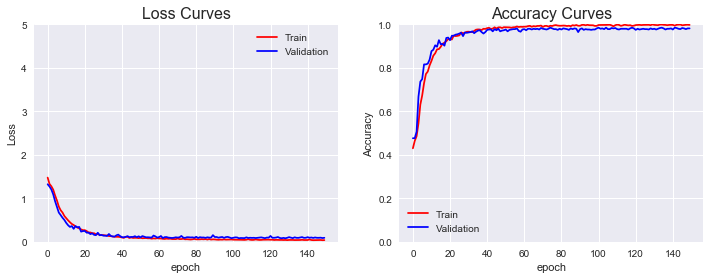

In [144]:
plot_results(cnn_hist_shape, 15)

Now the trained model is ready for testing on unseen data. Following function will check the classwise score of classified testing data with unseen testing data.

Confusion Matrix
[[ 55   0   1   0   0]
 [  0   9   0   0   0]
 [  4   0 346   1   1]
 [  0   0   0 137   1]
 [  0   0   2   2 181]]
Classification Report
              precision    recall  f1-score   support

     diamond       0.93      0.98      0.96        56
         hex       1.00      1.00      1.00         9
       round       0.99      0.98      0.99       352
      square       0.98      0.99      0.99       138
    triangle       0.99      0.98      0.98       185

   micro avg       0.98      0.98      0.98       740
   macro avg       0.98      0.99      0.98       740
weighted avg       0.98      0.98      0.98       740



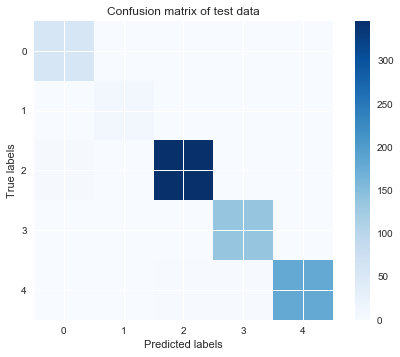

In [87]:
calConfusionMatrix(rescnn_model_shape, X_shape_test, target_shape_test, target_names_shape)

The CNN model for shape classification trained on raw images is slightly overfitted as training model performs better than the validation model.


Hence, let's train the model on augmented data to check if training data complexity will reduce the overfitting or not.

In [89]:
# Create Model
cnn_model_aug_shape = cnn_create_model(output_class=shape_classes, learning_rate = bs_lr, 
                                    momentum_param = bs_momentum, n1=bs_n1 , n2=bs_n2, n3=bs_n3, n4= bs_n4)

# Function call to fir model on ImageDataGenerator object of augmented
cnn_hist_aug_shape, rescnn_model_aug_shape = model_fitting(cnn_model_shape, batch_size_shape, n_epochs= bs_epoch,
                                    train_generator_data=CNN_aug_train_generator_shape,
                                    validation_generator_data=CNN_validation_generator_shape, no_train_images=N_train_images,
                                    no_val_images=N_val_images,  verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_122 (Activation)  (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 11, 11, 16)        9232      
_________________________________________________________________
activation_123 (Activation)  (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 3, 3, 64)          9280      
__________

148/148 [==============================] - 7s 49ms/step - loss: 0.6066 - categorical_accuracy: 0.8035 - acc: 0.8035 - f1_m: 0.7861 - precision_m: 0.8491 - recall_m: 0.7350 - val_loss: 0.1695 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9578 - val_precision_m: 0.9670 - val_recall_m: 0.9493
Epoch 13/150
148/148 [==============================] - 8s 53ms/step - loss: 0.5950 - categorical_accuracy: 0.8078 - acc: 0.8078 - f1_m: 0.7990 - precision_m: 0.8546 - recall_m: 0.7528 - val_loss: 0.1881 - val_categorical_accuracy: 0.9493 - val_acc: 0.9493 - val_f1_m: 0.9535 - val_precision_m: 0.9653 - val_recall_m: 0.9426
Epoch 14/150
148/148 [==============================] - 8s 53ms/step - loss: 0.5503 - categorical_accuracy: 0.8200 - acc: 0.8200 - f1_m: 0.8102 - precision_m: 0.8609 - recall_m: 0.7681 - val_loss: 0.1591 - val_categorical_accuracy: 0.9611 - val_acc: 0.9611 - val_f1_m: 0.9624 - val_precision_m: 0.9695 - val_recall_m: 0.9561
Epoch 15/150
148/148 [================

148/148 [==============================] - 8s 54ms/step - loss: 0.4386 - categorical_accuracy: 0.8657 - acc: 0.8657 - f1_m: 0.8620 - precision_m: 0.8986 - recall_m: 0.8302 - val_loss: 0.1369 - val_categorical_accuracy: 0.9628 - val_acc: 0.9628 - val_f1_m: 0.9667 - val_precision_m: 0.9745 - val_recall_m: 0.9595
Epoch 29/150
148/148 [==============================] - 7s 48ms/step - loss: 0.4580 - categorical_accuracy: 0.8483 - acc: 0.8483 - f1_m: 0.8474 - precision_m: 0.8796 - recall_m: 0.8192 - val_loss: 0.1309 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9590 - val_precision_m: 0.9658 - val_recall_m: 0.9527
Epoch 30/150
148/148 [==============================] - 7s 48ms/step - loss: 0.4357 - categorical_accuracy: 0.8606 - acc: 0.8606 - f1_m: 0.8591 - precision_m: 0.8952 - recall_m: 0.8280 - val_loss: 0.1391 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9593 - val_precision_m: 0.9627 - val_recall_m: 0.9561
Epoch 31/150
148/148 [================

Epoch 44/150
148/148 [==============================] - 8s 57ms/step - loss: 0.3434 - categorical_accuracy: 0.8952 - acc: 0.8952 - f1_m: 0.8913 - precision_m: 0.9132 - recall_m: 0.8720 - val_loss: 0.1089 - val_categorical_accuracy: 0.9696 - val_acc: 0.9696 - val_f1_m: 0.9719 - val_precision_m: 0.9761 - val_recall_m: 0.9679
Epoch 45/150
148/148 [==============================] - 8s 57ms/step - loss: 0.3790 - categorical_accuracy: 0.8906 - acc: 0.8906 - f1_m: 0.8874 - precision_m: 0.9116 - recall_m: 0.8660 - val_loss: 0.1101 - val_categorical_accuracy: 0.9645 - val_acc: 0.9645 - val_f1_m: 0.9676 - val_precision_m: 0.9727 - val_recall_m: 0.9628
Epoch 46/150
148/148 [==============================] - 8s 54ms/step - loss: 0.3461 - categorical_accuracy: 0.8995 - acc: 0.8995 - f1_m: 0.8992 - precision_m: 0.9216 - recall_m: 0.8792 - val_loss: 0.1145 - val_categorical_accuracy: 0.9679 - val_acc: 0.9679 - val_f1_m: 0.9701 - val_precision_m: 0.9761 - val_recall_m: 0.9645
Epoch 47/150
148/148 [===

148/148 [==============================] - 8s 54ms/step - loss: 0.2840 - categorical_accuracy: 0.9218 - acc: 0.9218 - f1_m: 0.9200 - precision_m: 0.9379 - recall_m: 0.9037 - val_loss: 0.0960 - val_categorical_accuracy: 0.9747 - val_acc: 0.9747 - val_f1_m: 0.9744 - val_precision_m: 0.9759 - val_recall_m: 0.9730
Epoch 61/150
148/148 [==============================] - 8s 55ms/step - loss: 0.2954 - categorical_accuracy: 0.9147 - acc: 0.9147 - f1_m: 0.9122 - precision_m: 0.9277 - recall_m: 0.8982 - val_loss: 0.0870 - val_categorical_accuracy: 0.9747 - val_acc: 0.9747 - val_f1_m: 0.9778 - val_precision_m: 0.9812 - val_recall_m: 0.9747
Epoch 62/150
148/148 [==============================] - 7s 50ms/step - loss: 0.2933 - categorical_accuracy: 0.9159 - acc: 0.9159 - f1_m: 0.9143 - precision_m: 0.9289 - recall_m: 0.9012 - val_loss: 0.1011 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9787 - val_precision_m: 0.9813 - val_recall_m: 0.9764
Epoch 63/150
148/148 [================

Epoch 76/150
148/148 [==============================] - 7s 46ms/step - loss: 0.2275 - categorical_accuracy: 0.9383 - acc: 0.9383 - f1_m: 0.9369 - precision_m: 0.9483 - recall_m: 0.9265 - val_loss: 0.0843 - val_categorical_accuracy: 0.9831 - val_acc: 0.9831 - val_f1_m: 0.9830 - val_precision_m: 0.9865 - val_recall_m: 0.9797
Epoch 77/150
148/148 [==============================] - 7s 45ms/step - loss: 0.2405 - categorical_accuracy: 0.9345 - acc: 0.9345 - f1_m: 0.9337 - precision_m: 0.9439 - recall_m: 0.9244 - val_loss: 0.0761 - val_categorical_accuracy: 0.9814 - val_acc: 0.9814 - val_f1_m: 0.9821 - val_precision_m: 0.9864 - val_recall_m: 0.9780
Epoch 78/150
148/148 [==============================] - 8s 51ms/step - loss: 0.2255 - categorical_accuracy: 0.9425 - acc: 0.9425 - f1_m: 0.9406 - precision_m: 0.9540 - recall_m: 0.9286 - val_loss: 0.0847 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9796 - val_precision_m: 0.9813 - val_recall_m: 0.9780
Epoch 79/150
148/148 [===

Epoch 92/150
148/148 [==============================] - 8s 51ms/step - loss: 0.1961 - categorical_accuracy: 0.9489 - acc: 0.9489 - f1_m: 0.9485 - precision_m: 0.9578 - recall_m: 0.9400 - val_loss: 0.0804 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9872 - val_precision_m: 0.9898 - val_recall_m: 0.9848
Epoch 93/150
148/148 [==============================] - 8s 51ms/step - loss: 0.2135 - categorical_accuracy: 0.9447 - acc: 0.9447 - f1_m: 0.9449 - precision_m: 0.9553 - recall_m: 0.9354 - val_loss: 0.0820 - val_categorical_accuracy: 0.9831 - val_acc: 0.9831 - val_f1_m: 0.9847 - val_precision_m: 0.9864 - val_recall_m: 0.9831
Epoch 94/150
148/148 [==============================] - 8s 52ms/step - loss: 0.2033 - categorical_accuracy: 0.9434 - acc: 0.9434 - f1_m: 0.9447 - precision_m: 0.9534 - recall_m: 0.9367 - val_loss: 0.0800 - val_categorical_accuracy: 0.9831 - val_acc: 0.9831 - val_f1_m: 0.9821 - val_precision_m: 0.9864 - val_recall_m: 0.9780
Epoch 95/150
148/148 [===

Epoch 108/150
148/148 [==============================] - 8s 51ms/step - loss: 0.2127 - categorical_accuracy: 0.9421 - acc: 0.9421 - f1_m: 0.9426 - precision_m: 0.9518 - recall_m: 0.9341 - val_loss: 0.0686 - val_categorical_accuracy: 0.9916 - val_acc: 0.9916 - val_f1_m: 0.9915 - val_precision_m: 0.9932 - val_recall_m: 0.9899
Epoch 109/150
148/148 [==============================] - 8s 51ms/step - loss: 0.1913 - categorical_accuracy: 0.9510 - acc: 0.9510 - f1_m: 0.9498 - precision_m: 0.9595 - recall_m: 0.9409 - val_loss: 0.0778 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9872 - val_precision_m: 0.9899 - val_recall_m: 0.9848
Epoch 110/150
148/148 [==============================] - 7s 47ms/step - loss: 0.1764 - categorical_accuracy: 0.9565 - acc: 0.9565 - f1_m: 0.9547 - precision_m: 0.9622 - recall_m: 0.9476 - val_loss: 0.0751 - val_categorical_accuracy: 0.9882 - val_acc: 0.9882 - val_f1_m: 0.9898 - val_precision_m: 0.9916 - val_recall_m: 0.9882
Epoch 111/150
148/148 

148/148 [==============================] - 7s 48ms/step - loss: 0.1896 - categorical_accuracy: 0.9510 - acc: 0.9510 - f1_m: 0.9521 - precision_m: 0.9597 - recall_m: 0.9451 - val_loss: 0.0644 - val_categorical_accuracy: 0.9916 - val_acc: 0.9916 - val_f1_m: 0.9924 - val_precision_m: 0.9932 - val_recall_m: 0.9916
Epoch 125/150
148/148 [==============================] - 7s 48ms/step - loss: 0.1748 - categorical_accuracy: 0.9573 - acc: 0.9573 - f1_m: 0.9577 - precision_m: 0.9644 - recall_m: 0.9514 - val_loss: 0.0684 - val_categorical_accuracy: 0.9865 - val_acc: 0.9865 - val_f1_m: 0.9847 - val_precision_m: 0.9865 - val_recall_m: 0.9831
Epoch 126/150
148/148 [==============================] - 7s 46ms/step - loss: 0.1774 - categorical_accuracy: 0.9569 - acc: 0.9569 - f1_m: 0.9545 - precision_m: 0.9619 - recall_m: 0.9476 - val_loss: 0.0695 - val_categorical_accuracy: 0.9865 - val_acc: 0.9865 - val_f1_m: 0.9864 - val_precision_m: 0.9882 - val_recall_m: 0.9848
Epoch 127/150
148/148 [=============

148/148 [==============================] - 7s 51ms/step - loss: 0.1553 - categorical_accuracy: 0.9654 - acc: 0.9654 - f1_m: 0.9658 - precision_m: 0.9709 - recall_m: 0.9611 - val_loss: 0.0720 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9856 - val_precision_m: 0.9882 - val_recall_m: 0.9831
Epoch 141/150
148/148 [==============================] - 7s 46ms/step - loss: 0.1589 - categorical_accuracy: 0.9607 - acc: 0.9607 - f1_m: 0.9591 - precision_m: 0.9669 - recall_m: 0.9519 - val_loss: 0.0690 - val_categorical_accuracy: 0.9932 - val_acc: 0.9932 - val_f1_m: 0.9932 - val_precision_m: 0.9949 - val_recall_m: 0.9916
Epoch 142/150
148/148 [==============================] - 7s 46ms/step - loss: 0.1596 - categorical_accuracy: 0.9594 - acc: 0.9594 - f1_m: 0.9597 - precision_m: 0.9660 - recall_m: 0.9539 - val_loss: 0.0590 - val_categorical_accuracy: 0.9916 - val_acc: 0.9916 - val_f1_m: 0.9905 - val_precision_m: 0.9930 - val_recall_m: 0.9882
Epoch 143/150
148/148 [=============

From the plot, overfitting concern seems to be correct. By augmenting the training data, model is able to bring higher validation performance than trainig data. 

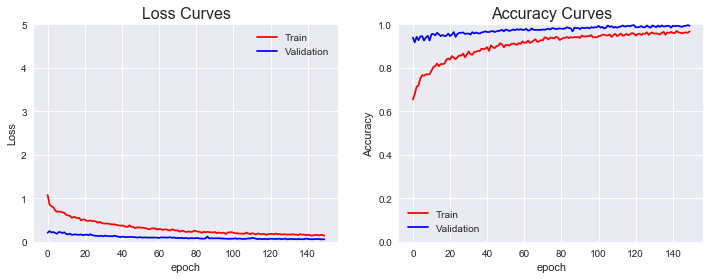

In [145]:
plot_results(cnn_hist_aug_shape, 15)

Now the trained model is ready for testing on unseen data. Following function will check the classwise score of classified testing data with unseen testing data.

Confusion Matrix
[[ 56   0   0   0   0]
 [  0   9   0   0   0]
 [  0   0 350   1   1]
 [  0   0   0 137   1]
 [  0   0   2   0 183]]
Classification Report
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        56
         hex       1.00      1.00      1.00         9
       round       0.99      0.99      0.99       352
      square       0.99      0.99      0.99       138
    triangle       0.99      0.99      0.99       185

   micro avg       0.99      0.99      0.99       740
   macro avg       1.00      1.00      1.00       740
weighted avg       0.99      0.99      0.99       740



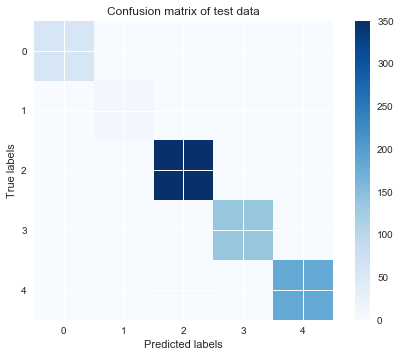

In [94]:
calConfusionMatrix(rescnn_model_aug_shape, X_shape_test, target_shape_test, target_names_shape)

## Sign- Type Analysis

Now similar sort of analysis will be perform for classifying traffic sign-type. Only different behaviour than previous task will be discussed in this section.

### Neural Network

Neural network model configuration will remian same as the sign-shape model except output layer nodes.

Creating and training the model for NN on sign-type data.

In [50]:
model_nn_type, hf_nn_type = create_model_nn(type_classes)
nn_type_hist, op_nn_type = model_fitting(model_nn_type, batch_size_type, n_epochs= 100,
                                    train_generator_data=CNN_train_generator_type, 
                                    validation_generator_data=CNN_validation_generator_type, no_train_images=N_train_images,
                                    no_val_images=N_val_images,  verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_75 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_76 (Activation)   (None, 16)                0         
Total para

Epoch 15/100
148/148 [==============================] - 2s 13ms/step - loss: 0.2959 - categorical_accuracy: 0.9417 - acc: 0.9417 - f1_m: 0.9261 - precision_m: 0.9838 - recall_m: 0.8775 - val_loss: 0.3407 - val_categorical_accuracy: 0.9122 - val_acc: 0.9122 - val_f1_m: 0.9086 - val_precision_m: 0.9692 - val_recall_m: 0.8581
Epoch 16/100
148/148 [==============================] - 3s 20ms/step - loss: 0.2779 - categorical_accuracy: 0.9417 - acc: 0.9417 - f1_m: 0.9298 - precision_m: 0.9832 - recall_m: 0.8851 - val_loss: 0.3330 - val_categorical_accuracy: 0.9172 - val_acc: 0.9172 - val_f1_m: 0.9138 - val_precision_m: 0.9679 - val_recall_m: 0.8682
Epoch 17/100
148/148 [==============================] - 3s 17ms/step - loss: 0.2603 - categorical_accuracy: 0.9493 - acc: 0.9493 - f1_m: 0.9361 - precision_m: 0.9847 - recall_m: 0.8948 - val_loss: 0.3243 - val_categorical_accuracy: 0.9324 - val_acc: 0.9324 - val_f1_m: 0.9160 - val_precision_m: 0.9647 - val_recall_m: 0.8750
Epoch 18/100
148/148 [===

Epoch 32/100
148/148 [==============================] - 2s 11ms/step - loss: 0.1306 - categorical_accuracy: 0.9797 - acc: 0.9797 - f1_m: 0.9761 - precision_m: 0.9922 - recall_m: 0.9615 - val_loss: 0.2326 - val_categorical_accuracy: 0.9392 - val_acc: 0.9392 - val_f1_m: 0.9425 - val_precision_m: 0.9731 - val_recall_m: 0.9172
Epoch 33/100
148/148 [==============================] - 2s 13ms/step - loss: 0.1261 - categorical_accuracy: 0.9780 - acc: 0.9780 - f1_m: 0.9757 - precision_m: 0.9926 - recall_m: 0.9603 - val_loss: 0.2245 - val_categorical_accuracy: 0.9375 - val_acc: 0.9375 - val_f1_m: 0.9447 - val_precision_m: 0.9733 - val_recall_m: 0.9206
Epoch 34/100
148/148 [==============================] - 3s 20ms/step - loss: 0.1228 - categorical_accuracy: 0.9763 - acc: 0.9763 - f1_m: 0.9772 - precision_m: 0.9936 - recall_m: 0.9624 - val_loss: 0.2220 - val_categorical_accuracy: 0.9443 - val_acc: 0.9443 - val_f1_m: 0.9476 - val_precision_m: 0.9748 - val_recall_m: 0.9240
Epoch 35/100
148/148 [===

Epoch 49/100
148/148 [==============================] - 2s 14ms/step - loss: 0.0734 - categorical_accuracy: 0.9899 - acc: 0.9899 - f1_m: 0.9878 - precision_m: 0.9966 - recall_m: 0.9797 - val_loss: 0.1972 - val_categorical_accuracy: 0.9527 - val_acc: 0.9527 - val_f1_m: 0.9544 - val_precision_m: 0.9736 - val_recall_m: 0.9375
Epoch 50/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0711 - categorical_accuracy: 0.9890 - acc: 0.9890 - f1_m: 0.9878 - precision_m: 0.9970 - recall_m: 0.9793 - val_loss: 0.1948 - val_categorical_accuracy: 0.9510 - val_acc: 0.9510 - val_f1_m: 0.9564 - val_precision_m: 0.9740 - val_recall_m: 0.9409
Epoch 51/100
148/148 [==============================] - 2s 17ms/step - loss: 0.0688 - categorical_accuracy: 0.9916 - acc: 0.9916 - f1_m: 0.9887 - precision_m: 0.9953 - recall_m: 0.9827 - val_loss: 0.1884 - val_categorical_accuracy: 0.9527 - val_acc: 0.9527 - val_f1_m: 0.9581 - val_precision_m: 0.9756 - val_recall_m: 0.9426
Epoch 52/100
148/148 [===

Epoch 66/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0455 - categorical_accuracy: 0.9958 - acc: 0.9958 - f1_m: 0.9946 - precision_m: 0.9995 - recall_m: 0.9899 - val_loss: 0.1740 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9593 - val_precision_m: 0.9702 - val_recall_m: 0.9493
Epoch 67/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0450 - categorical_accuracy: 0.9966 - acc: 0.9966 - f1_m: 0.9945 - precision_m: 0.9992 - recall_m: 0.9903 - val_loss: 0.1769 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9635 - val_precision_m: 0.9774 - val_recall_m: 0.9510
Epoch 68/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0445 - categorical_accuracy: 0.9962 - acc: 0.9962 - f1_m: 0.9946 - precision_m: 0.9992 - recall_m: 0.9903 - val_loss: 0.1783 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9599 - val_precision_m: 0.9740 - val_recall_m: 0.9476
Epoch 69/100
148/148 [===

Epoch 83/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0322 - categorical_accuracy: 0.9983 - acc: 0.9983 - f1_m: 0.9972 - precision_m: 0.9996 - recall_m: 0.9949 - val_loss: 0.1682 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9629 - val_precision_m: 0.9707 - val_recall_m: 0.9561
Epoch 84/100
148/148 [==============================] - 2s 16ms/step - loss: 0.0309 - categorical_accuracy: 0.9992 - acc: 0.9992 - f1_m: 0.9980 - precision_m: 1.0000 - recall_m: 0.9962 - val_loss: 0.1706 - val_categorical_accuracy: 0.9595 - val_acc: 0.9595 - val_f1_m: 0.9639 - val_precision_m: 0.9724 - val_recall_m: 0.9561
Epoch 85/100
148/148 [==============================] - 2s 14ms/step - loss: 0.0303 - categorical_accuracy: 0.9992 - acc: 0.9992 - f1_m: 0.9983 - precision_m: 1.0000 - recall_m: 0.9966 - val_loss: 0.1683 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9611 - val_precision_m: 0.9724 - val_recall_m: 0.9510
Epoch 86/100
148/148 [===

148/148 [==============================] - 2s 14ms/step - loss: 0.0237 - categorical_accuracy: 0.9996 - acc: 0.9996 - f1_m: 0.9996 - precision_m: 1.0000 - recall_m: 0.9992 - val_loss: 0.1651 - val_categorical_accuracy: 0.9561 - val_acc: 0.9561 - val_f1_m: 0.9597 - val_precision_m: 0.9675 - val_recall_m: 0.9527
Epoch 100/100
148/148 [==============================] - 3s 19ms/step - loss: 0.0233 - categorical_accuracy: 0.9996 - acc: 0.9996 - f1_m: 0.9991 - precision_m: 1.0000 - recall_m: 0.9983 - val_loss: 0.1701 - val_categorical_accuracy: 0.9578 - val_acc: 0.9578 - val_f1_m: 0.9613 - val_precision_m: 0.9708 - val_recall_m: 0.9527


Plotting the result of NN model. This model also exhibits the same overfitting behaviour of training model.

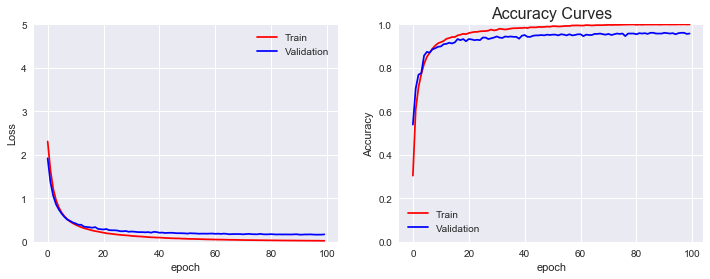

In [51]:
plot_results(history=nn_type_hist, epochs=100)

#### Extracting the hidden features

Plotting TNSE plots for input layer and hidden layer to analyze clustring.

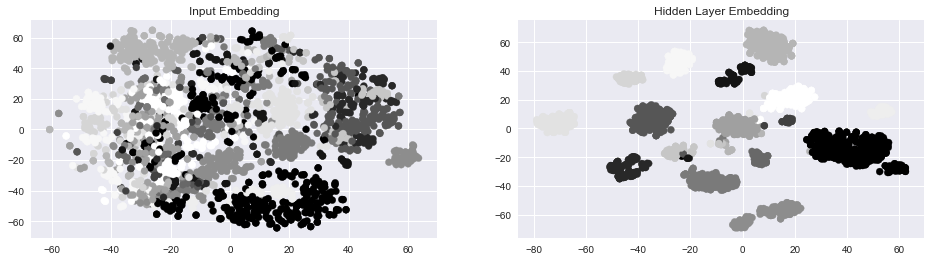

In [71]:
# For training data

inputs_type_train, y_type_train, features_type_train = extract_hidden_features(hf_nn_type,
                                        CNN_train_generator_type, N_train_images, batch_size_type)

plotTsne(inputs_type_train, y_type_train, features_type_train)

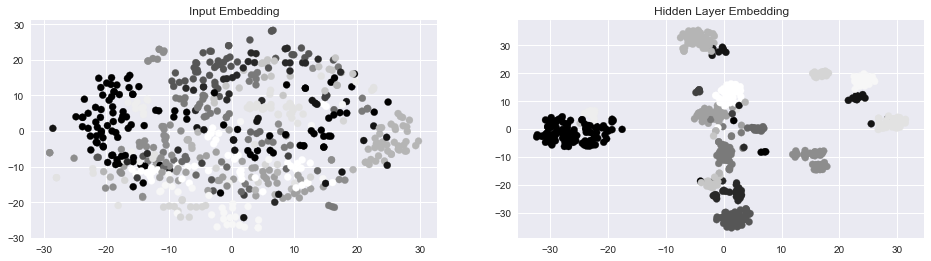

In [171]:
# For Validation data
inputs_type_test, y_type_test, features_type_test = extract_hidden_features(hf_nn_type,
                                        CNN_validation_generator_type, N_val_images, batch_size_type)

plotTsne(inputs_type_test, y_type_test, features_type_test)

### Deep Learning CNN

#### Hyper Parameter Tuning

Tuning with KerasClassifier and RandomizedSearchCv with 2 fold cross validation to identify best parameters to boost the performance.

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# training neural network without param tuning ( yet to be added here)

import time
t0= time.time()

# create model
hyper_type_model_1 = KerasClassifier(build_fn=cnn_create_model, verbose=True)

# define the grid search parameters
learn_rate = [0.001,0.01,0.1]
momentum = [0.5,0.9]
batch_size_list = [15]
epochs_n = [100,150]
opclass = [16]
n1= [32, 64, 128]
n2= [32, 64, 128]
n3= [32, 64]
n4= [32, 64]

# commenting the code of randomsearchcv model fitting
# param_grid_type = dict(batch_size=batch_size_list, epochs = epochs_n, output_class = opclass, learning_rate=learn_rate,
#                   momentum_param=momentum, n1 =n1, n2=n2, n3=n3, n4=n4)
# grid_type = RandomizedSearchCV(estimator=hyper_type_model_1 , param_distributions=param_grid_type, n_jobs=1, n_iter= 5, cv=2)
# grid_result_type = grid_type.fit(X_type_trainval , cat_target_type_trainval)

t1 = time.time()
print("Time elapsed: ", str(t1 - t0))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
activation_127 (Activation)  (None, 26, 26, 128)       0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 11, 11, 64)        73792     
_________________________________________________________________
activation_128 (Activation)  (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 3, 3, 32)          18464     
__________

1479/1479 [==============================] - 6s 4ms/sample - loss: 0.8670 - categorical_accuracy: 0.7579 - acc: 0.7579 - f1_m: 0.7433 - precision_m: 0.8876 - recall_m: 0.6460
Epoch 28/100
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.7900 - categorical_accuracy: 0.7755 - acc: 0.7755 - f1_m: 0.7503 - precision_m: 0.8814 - recall_m: 0.6606
Epoch 29/100
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.7933 - categorical_accuracy: 0.7755 - acc: 0.7755 - f1_m: 0.7524 - precision_m: 0.8806 - recall_m: 0.6631
Epoch 30/100
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.7777 - categorical_accuracy: 0.7945 - acc: 0.7945 - f1_m: 0.7740 - precision_m: 0.8987 - recall_m: 0.68801s - loss: 0.7902 - categorical_accuracy: 0.7924 - acc: 0.7924 - f1_m: 0.7712 - 
Epoch 31/100
1479/1479 [==============================] - 7s 5ms/sample - loss: 0.7685 - categorical_accuracy: 0.7924 - acc: 0.7924 - f1_m: 0.7680 - precision_m: 0.8937 - recall_m: 

1479/1479 [==============================] - 6s 4ms/sample - loss: 0.4498 - categorical_accuracy: 0.8864 - acc: 0.8864 - f1_m: 0.8757 - precision_m: 0.9348 - recall_m: 0.82721s - loss: 0.4329 - categorical_accuracy: 0.8961 - acc: 0.8961 - f1_m: 0.8863 - precision_m: 0.9437 - recall_m: 0.83 - ETA: 1s - loss: 0.4313 - categorical_accuracy: 0.8966 - acc: 0.8966 - f1_m: 0.886
Epoch 65/100
1479/1479 [==============================] - ETA: 0s - loss: 0.4667 - categorical_accuracy: 0.8728 - acc: 0.8728 - f1_m: 0.8709 - precision_m: 0.9222 - recall_m: 0.82 - 7s 4ms/sample - loss: 0.4651 - categorical_accuracy: 0.8736 - acc: 0.8736 - f1_m: 0.8722 - precision_m: 0.9230 - recall_m: 0.8303
Epoch 66/100
1479/1479 [==============================] - 7s 5ms/sample - loss: 0.4390 - categorical_accuracy: 0.8918 - acc: 0.8918 - f1_m: 0.8867 - precision_m: 0.9390 - recall_m: 0.8426
Epoch 67/100
1479/1479 [==============================] - 6s 4ms/sample - loss: 0.4447 - categorical_accuracy: 0.8878 - acc: 

1479/1479 [==============================] - 2s 2ms/sample - loss: 0.1461 - categorical_accuracy: 0.9892 - acc: 0.9892 - f1_m: 0.9887 - precision_m: 0.9932 - recall_m: 0.98451s - loss: 0.1377 - categorical_accuracy: 0.9946 - acc: 0.9946 - f1_m: 0.9917 - 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
activation_132 (Activation)  (None, 26, 26, 128)       0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 11, 11, 64)        73792     
_________________________________________________________________
activation_133 (Activation)  (None, 11, 11, 64)        0         
___________________

1480/1480 [==============================] - 7s 5ms/sample - loss: 0.7256 - categorical_accuracy: 0.8014 - acc: 0.8014 - f1_m: 0.7844 - precision_m: 0.9057 - recall_m: 0.6983
Epoch 29/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.7150 - categorical_accuracy: 0.7986 - acc: 0.7986 - f1_m: 0.7882 - precision_m: 0.9076 - recall_m: 0.7040
Epoch 30/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.7209 - categorical_accuracy: 0.8088 - acc: 0.8088 - f1_m: 0.7883 - precision_m: 0.9044 - recall_m: 0.7040
Epoch 31/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.6302 - categorical_accuracy: 0.8365 - acc: 0.8365 - f1_m: 0.8164 - precision_m: 0.9184 - recall_m: 0.7397
Epoch 32/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.6309 - categorical_accuracy: 0.8264 - acc: 0.8264 - f1_m: 0.8153 - precision_m: 0.9163 - recall_m: 0.7401
Epoch 33/100
1480/1480 [==============================] - 7s 5ms/sample -

1480/1480 [==============================] - 8s 5ms/sample - loss: 0.3754 - categorical_accuracy: 0.9034 - acc: 0.9034 - f1_m: 0.9046 - precision_m: 0.9425 - recall_m: 0.8717
Epoch 69/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.3558 - categorical_accuracy: 0.9162 - acc: 0.9162 - f1_m: 0.9146 - precision_m: 0.9560 - recall_m: 0.8788
Epoch 70/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.3513 - categorical_accuracy: 0.9142 - acc: 0.9142 - f1_m: 0.9069 - precision_m: 0.9462 - recall_m: 0.8734
Epoch 71/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.3441 - categorical_accuracy: 0.9189 - acc: 0.9189 - f1_m: 0.9175 - precision_m: 0.9475 - recall_m: 0.8916
Epoch 72/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.3396 - categorical_accuracy: 0.9169 - acc: 0.9169 - f1_m: 0.9180 - precision_m: 0.9494 - recall_m: 0.8902
Epoch 73/100
1480/1480 [==============================] - 8s 5ms/sample -

Epoch 1/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 2.6874 - categorical_accuracy: 0.1853 - acc: 0.1853 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+004s - loss: 2.7420 - categorical_accuracy: 0.1879 - acc: 0.1879 -
Epoch 2/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 2.2477 - categorical_accuracy: 0.3130 - acc: 0.3130 - f1_m: 0.1787 - precision_m: 0.6350 - recall_m: 0.1086
Epoch 3/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.6526 - categorical_accuracy: 0.5098 - acc: 0.5098 - f1_m: 0.4048 - precision_m: 0.8008 - recall_m: 0.2866
Epoch 4/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.2185 - categorical_accuracy: 0.6220 - acc: 0.6220 - f1_m: 0.5893 - precision_m: 0.8267 - recall_m: 0.4682
Epoch 5/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 1.0251 - categorical_accuracy: 0.6687 - acc: 0.6687 - f1_m: 0.6573 - precision_m: 0.8503 - recall

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.1971 - categorical_accuracy: 0.9439 - acc: 0.9439 - f1_m: 0.9510 - precision_m: 0.9681 - recall_m: 0.9354
Epoch 41/100
1479/1479 [==============================] - 5s 3ms/sample - loss: 0.2052 - categorical_accuracy: 0.9446 - acc: 0.9446 - f1_m: 0.9449 - precision_m: 0.9592 - recall_m: 0.9320
Epoch 42/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.2319 - categorical_accuracy: 0.9277 - acc: 0.9277 - f1_m: 0.9362 - precision_m: 0.9606 - recall_m: 0.9145
Epoch 43/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.2257 - categorical_accuracy: 0.9385 - acc: 0.9385 - f1_m: 0.9438 - precision_m: 0.9656 - recall_m: 0.9248
Epoch 44/100
1479/1479 [==============================] - 5s 4ms/sample - loss: 0.1907 - categorical_accuracy: 0.9473 - acc: 0.9473 - f1_m: 0.9513 - precision_m: 0.9678 - recall_m: 0.9363
Epoch 45/100
1479/1479 [==============================] - 5s 3ms/sample -

1479/1479 [==============================] - 4s 3ms/sample - loss: 0.1594 - categorical_accuracy: 0.9527 - acc: 0.9527 - f1_m: 0.9561 - precision_m: 0.9715 - recall_m: 0.9421
Epoch 82/100
1479/1479 [==============================] - 4s 3ms/sample - loss: 0.1251 - categorical_accuracy: 0.9696 - acc: 0.9696 - f1_m: 0.9701 - precision_m: 0.9816 - recall_m: 0.9596
Epoch 83/100
1479/1479 [==============================] - 4s 2ms/sample - loss: 0.1520 - categorical_accuracy: 0.9594 - acc: 0.9594 - f1_m: 0.9599 - precision_m: 0.9709 - recall_m: 0.9502
Epoch 84/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1638 - categorical_accuracy: 0.9520 - acc: 0.9520 - f1_m: 0.9575 - precision_m: 0.9723 - recall_m: 0.9441
Epoch 85/100
1479/1479 [==============================] - 3s 2ms/sample - loss: 0.1634 - categorical_accuracy: 0.9608 - acc: 0.9608 - f1_m: 0.9609 - precision_m: 0.9751 - recall_m: 0.9481
Epoch 86/100
1479/1479 [==============================] - 4s 2ms/sample -

1480/1480 [==============================] - 5s 3ms/sample - loss: 0.5600 - categorical_accuracy: 0.8419 - acc: 0.8419 - f1_m: 0.8361 - precision_m: 0.9041 - recall_m: 0.7818
Epoch 9/100
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.5634 - categorical_accuracy: 0.8419 - acc: 0.8419 - f1_m: 0.8386 - precision_m: 0.9019 - recall_m: 0.7872
Epoch 10/100
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.4629 - categorical_accuracy: 0.8757 - acc: 0.8757 - f1_m: 0.8736 - precision_m: 0.9278 - recall_m: 0.8286
Epoch 11/100
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.4272 - categorical_accuracy: 0.8905 - acc: 0.8905 - f1_m: 0.8867 - precision_m: 0.9334 - recall_m: 0.8478
Epoch 12/100
1480/1480 [==============================] - 6s 4ms/sample - loss: 0.4259 - categorical_accuracy: 0.8824 - acc: 0.8824 - f1_m: 0.8821 - precision_m: 0.9201 - recall_m: 0.8492
Epoch 13/100
1480/1480 [==============================] - 6s 4ms/sample - 

1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1613 - categorical_accuracy: 0.9608 - acc: 0.9608 - f1_m: 0.9637 - precision_m: 0.9719 - recall_m: 0.9562
Epoch 45/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1400 - categorical_accuracy: 0.9716 - acc: 0.9716 - f1_m: 0.9696 - precision_m: 0.9781 - recall_m: 0.9616
Epoch 46/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1518 - categorical_accuracy: 0.9669 - acc: 0.9669 - f1_m: 0.9671 - precision_m: 0.9750 - recall_m: 0.9599
Epoch 47/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1569 - categorical_accuracy: 0.9635 - acc: 0.9635 - f1_m: 0.9634 - precision_m: 0.9712 - recall_m: 0.9562
Epoch 48/100
1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1536 - categorical_accuracy: 0.9628 - acc: 0.9628 - f1_m: 0.9612 - precision_m: 0.9723 - recall_m: 0.9515
Epoch 49/100
1480/1480 [==============================] - 4s 3ms/sample -

1480/1480 [==============================] - 4s 3ms/sample - loss: 0.1133 - categorical_accuracy: 0.9757 - acc: 0.9757 - f1_m: 0.9770 - precision_m: 0.9843 - recall_m: 0.9704
Epoch 86/100
1480/1480 [==============================] - 4s 2ms/sample - loss: 0.1193 - categorical_accuracy: 0.9696 - acc: 0.9696 - f1_m: 0.9696 - precision_m: 0.9769 - recall_m: 0.9630
Epoch 87/100
1480/1480 [==============================] - 4s 2ms/sample - loss: 0.1117 - categorical_accuracy: 0.9709 - acc: 0.9709 - f1_m: 0.9729 - precision_m: 0.9799 - recall_m: 0.9663
Epoch 88/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1118 - categorical_accuracy: 0.9696 - acc: 0.9696 - f1_m: 0.9711 - precision_m: 0.9815 - recall_m: 0.9616
Epoch 89/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 0.1094 - categorical_accuracy: 0.9736 - acc: 0.9736 - f1_m: 0.9728 - precision_m: 0.9828 - recall_m: 0.9636
Epoch 90/100
1480/1480 [==============================] - 4s 2ms/sample -

1479/1479 [==============================] - 7s 5ms/sample - loss: 2.7513 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 13/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 2.7401 - categorical_accuracy: 0.1920 - acc: 0.1920 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 14/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 2.7341 - categorical_accuracy: 0.1981 - acc: 0.1981 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 15/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 2.7166 - categorical_accuracy: 0.2035 - acc: 0.2035 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 16/100
1479/1479 [==============================] - 7s 5ms/sample - loss: 2.7085 - categorical_accuracy: 0.2008 - acc: 0.2008 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 17/100


1479/1479 [==============================] - 8s 6ms/sample - loss: 1.6218 - categorical_accuracy: 0.5774 - acc: 0.5774 - f1_m: 0.4247 - precision_m: 0.8747 - recall_m: 0.2887
Epoch 54/100
1479/1479 [==============================] - 9s 6ms/sample - loss: 1.6018 - categorical_accuracy: 0.5686 - acc: 0.5686 - f1_m: 0.4230 - precision_m: 0.8957 - recall_m: 0.2878
Epoch 55/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 1.5496 - categorical_accuracy: 0.5889 - acc: 0.5889 - f1_m: 0.4696 - precision_m: 0.8796 - recall_m: 0.3291
Epoch 56/100
1479/1479 [==============================] - 8s 6ms/sample - loss: 1.5520 - categorical_accuracy: 0.5835 - acc: 0.5835 - f1_m: 0.4629 - precision_m: 0.8613 - recall_m: 0.3262
Epoch 57/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 1.4784 - categorical_accuracy: 0.6241 - acc: 0.6241 - f1_m: 0.4738 - precision_m: 0.8680 - recall_m: 0.3380
Epoch 58/100
1479/1479 [==============================] - 7s 5ms/sample -

1479/1479 [==============================] - 8s 6ms/sample - loss: 0.8309 - categorical_accuracy: 0.7890 - acc: 0.7890 - f1_m: 0.7481 - precision_m: 0.8834 - recall_m: 0.65547s - loss: 0.8270 - categorical_accuracy - ETA: 4s - loss: 0.846
Epoch 94/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 0.8166 - categorical_accuracy: 0.7890 - acc: 0.7890 - f1_m: 0.7546 - precision_m: 0.8930 - recall_m: 0.6595
Epoch 95/100
1479/1479 [==============================] - 8s 6ms/sample - loss: 0.8172 - categorical_accuracy: 0.8046 - acc: 0.8046 - f1_m: 0.7621 - precision_m: 0.8984 - recall_m: 0.66911s - loss: 0.8015 - categorical_accuracy: 0.8140 - acc: 0.8140 - f1_m: 0.7667 - pr
Epoch 96/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 0.8137 - categorical_accuracy: 0.7863 - acc: 0.7863 - f1_m: 0.7613 - precision_m: 0.8968 - recall_m: 0.6680
Epoch 97/100
1479/1479 [==============================] - 8s 5ms/sample - loss: 0.8089 - categorical_accuracy: 0.79

1480/1480 [==============================] - 9s 6ms/sample - loss: 2.6843 - categorical_accuracy: 0.2007 - acc: 0.2007 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 18/100
1480/1480 [==============================] - 8s 6ms/sample - loss: 2.6671 - categorical_accuracy: 0.2000 - acc: 0.2000 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 19/100
1480/1480 [==============================] - 9s 6ms/sample - loss: 2.6668 - categorical_accuracy: 0.2054 - acc: 0.2054 - f1_m: 0.0013 - precision_m: 0.0101 - recall_m: 6.7340e-041s - loss: 2.6641 - categorical_accuracy: 0.2084 - acc: 0.2084 - f1_m: 0.0014 - precision_m: 0.0115 - reca - ETA: 0s - loss: 2.6698 - categorical_accuracy: 0.2049 - acc: 0.2049 - f1_m: 0.0013 - precision_m: 0.0105 - recall_m: 7.
Epoch 20/100
1480/1480 [==============================] - 9s 6ms/sample - loss: 2.6426 - categorical_accuracy: 0.2122 - acc: 0.2122 - f1_m: 0.0025 - precision_m: 0.0202 - recall_m: 0.0013
Epoch

1480/1480 [==============================] - 8s 6ms/sample - loss: 1.7390 - categorical_accuracy: 0.5459 - acc: 0.5459 - f1_m: 0.3820 - precision_m: 0.8632 - recall_m: 0.2545
Epoch 53/100
1480/1480 [==============================] - 8s 6ms/sample - loss: 1.6923 - categorical_accuracy: 0.5595 - acc: 0.5595 - f1_m: 0.3860 - precision_m: 0.8473 - recall_m: 0.2599
Epoch 54/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 1.6470 - categorical_accuracy: 0.5730 - acc: 0.5730 - f1_m: 0.4148 - precision_m: 0.8534 - recall_m: 0.2818
Epoch 55/100
1480/1480 [==============================] - 8s 6ms/sample - loss: 1.6216 - categorical_accuracy: 0.5709 - acc: 0.5709 - f1_m: 0.4185 - precision_m: 0.8446 - recall_m: 0.2865
Epoch 56/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 1.6028 - categorical_accuracy: 0.5730 - acc: 0.5730 - f1_m: 0.4407 - precision_m: 0.8628 - recall_m: 0.3061
Epoch 57/100
1480/1480 [==============================] - 8s 5ms/sample -

1480/1480 [==============================] - 7s 5ms/sample - loss: 0.8552 - categorical_accuracy: 0.7932 - acc: 0.7932 - f1_m: 0.7488 - precision_m: 0.8973 - recall_m: 0.6502
Epoch 95/100
1480/1480 [==============================] - 7s 5ms/sample - loss: 0.8585 - categorical_accuracy: 0.7966 - acc: 0.7966 - f1_m: 0.7418 - precision_m: 0.8949 - recall_m: 0.6407
Epoch 96/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.8849 - categorical_accuracy: 0.7838 - acc: 0.7838 - f1_m: 0.7471 - precision_m: 0.8958 - recall_m: 0.6481
Epoch 97/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.8461 - categorical_accuracy: 0.8041 - acc: 0.8041 - f1_m: 0.7574 - precision_m: 0.8954 - recall_m: 0.6643
Epoch 98/100
1480/1480 [==============================] - 8s 5ms/sample - loss: 0.8197 - categorical_accuracy: 0.8000 - acc: 0.8000 - f1_m: 0.7668 - precision_m: 0.9099 - recall_m: 0.6707
Epoch 99/100
1480/1480 [==============================] - 8s 6ms/sample -

1479/1479 [==============================] - 2s 2ms/sample - loss: 0.4696 - categorical_accuracy: 0.8580 - acc: 0.8580 - f1_m: 0.8526 - precision_m: 0.9211 - recall_m: 0.7987
Epoch 24/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.4547 - categorical_accuracy: 0.8776 - acc: 0.8776 - f1_m: 0.8705 - precision_m: 0.9363 - recall_m: 0.8175
Epoch 25/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.4300 - categorical_accuracy: 0.8763 - acc: 0.8763 - f1_m: 0.8776 - precision_m: 0.9314 - recall_m: 0.8323
Epoch 26/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.4430 - categorical_accuracy: 0.8614 - acc: 0.8614 - f1_m: 0.8674 - precision_m: 0.9272 - recall_m: 0.8177
Epoch 27/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.4375 - categorical_accuracy: 0.8776 - acc: 0.8776 - f1_m: 0.8735 - precision_m: 0.9343 - recall_m: 0.8238
Epoch 28/100
1479/1479 [==============================] - 2s 1ms/sample -

1479/1479 [==============================] - 2s 1ms/sample - loss: 0.2600 - categorical_accuracy: 0.9236 - acc: 0.9236 - f1_m: 0.9291 - precision_m: 0.9570 - recall_m: 0.9044
Epoch 65/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.2471 - categorical_accuracy: 0.9317 - acc: 0.9317 - f1_m: 0.9295 - precision_m: 0.9540 - recall_m: 0.9080
Epoch 66/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.2382 - categorical_accuracy: 0.9405 - acc: 0.9405 - f1_m: 0.9442 - precision_m: 0.9617 - recall_m: 0.9284
Epoch 67/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.2598 - categorical_accuracy: 0.9297 - acc: 0.9297 - f1_m: 0.9322 - precision_m: 0.9534 - recall_m: 0.9131
Epoch 68/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 0.2227 - categorical_accuracy: 0.9459 - acc: 0.9459 - f1_m: 0.9486 - precision_m: 0.9716 - recall_m: 0.9282
Epoch 69/100
1479/1479 [==============================] - 2s 1ms/sample -

Epoch 1/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 2.7304 - categorical_accuracy: 0.1655 - acc: 0.1655 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 2.6094 - categorical_accuracy: 0.2061 - acc: 0.2061 - f1_m: 0.0063 - precision_m: 0.0505 - recall_m: 0.0034
Epoch 3/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 2.4876 - categorical_accuracy: 0.2459 - acc: 0.2459 - f1_m: 0.0289 - precision_m: 0.1886 - recall_m: 0.0158
Epoch 4/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 2.2671 - categorical_accuracy: 0.3223 - acc: 0.3223 - f1_m: 0.1323 - precision_m: 0.6017 - recall_m: 0.0768
Epoch 5/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 2.0171 - categorical_accuracy: 0.4162 - acc: 0.4162 - f1_m: 0.2648 - precision_m: 0.8058 - recall_m: 0.16460s - loss: 2.0289 - categorical_accuracy: 0.4121 - acc

1480/1480 [==============================] - 2s 2ms/sample - loss: 0.3459 - categorical_accuracy: 0.9061 - acc: 0.9061 - f1_m: 0.9028 - precision_m: 0.9428 - recall_m: 0.8680
Epoch 44/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3277 - categorical_accuracy: 0.9176 - acc: 0.9176 - f1_m: 0.9116 - precision_m: 0.9472 - recall_m: 0.8811
Epoch 45/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.3158 - categorical_accuracy: 0.9155 - acc: 0.9155 - f1_m: 0.9124 - precision_m: 0.9463 - recall_m: 0.8828
Epoch 46/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.2867 - categorical_accuracy: 0.9270 - acc: 0.9270 - f1_m: 0.9256 - precision_m: 0.9591 - recall_m: 0.8966
Epoch 47/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.2813 - categorical_accuracy: 0.9311 - acc: 0.9311 - f1_m: 0.9285 - precision_m: 0.9536 - recall_m: 0.9064
Epoch 48/100
1480/1480 [==============================] - 2s 1ms/sample -

1480/1480 [==============================] - 2s 2ms/sample - loss: 0.2328 - categorical_accuracy: 0.9446 - acc: 0.9446 - f1_m: 0.9468 - precision_m: 0.9657 - recall_m: 0.9303
Epoch 86/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 0.1886 - categorical_accuracy: 0.9581 - acc: 0.9581 - f1_m: 0.9582 - precision_m: 0.9747 - recall_m: 0.9434
Epoch 87/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.2030 - categorical_accuracy: 0.9500 - acc: 0.9500 - f1_m: 0.9482 - precision_m: 0.9641 - recall_m: 0.9340
Epoch 88/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.2156 - categorical_accuracy: 0.9473 - acc: 0.9473 - f1_m: 0.9480 - precision_m: 0.9694 - recall_m: 0.9293
Epoch 89/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 0.2128 - categorical_accuracy: 0.9500 - acc: 0.9500 - f1_m: 0.9499 - precision_m: 0.9664 - recall_m: 0.9347
Epoch 90/100
1480/1480 [==============================] - 2s 1ms/sample -

1479/1479 [==============================] - 3s 2ms/sample - loss: 2.6129 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+000s - loss: 2.6073 - categorical_accuracy: 0.1954 - acc: 0.1954 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.
Epoch 12/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6105 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 13/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6120 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 14/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6107 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 15/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6135 - ca

Epoch 51/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6131 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 52/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6107 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 53/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6114 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 54/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6131 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 55/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6079 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6087 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 91/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6099 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 92/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6115 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 93/100
1479/1479 [==============================] - 2s 1ms/sample - loss: 2.6156 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 94/100
1479/1479 [==============================] - 2s 2ms/sample - loss: 2.6069 - categorical_accuracy: 0.1893 - acc: 0.1893 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 95/100


1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5972 - categorical_accuracy: 0.1784 - acc: 0.1784 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 18/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5943 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 19/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5963 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 20/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5979 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 21/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5955 - categorical_accuracy: 0.1838 - acc: 0.1838 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 22/100


1480/1480 [==============================] - 3s 2ms/sample - loss: 2.5951 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+000s - loss: 2.5928 - categorical_accuracy: 0.1833 - acc: 0.1833 - f1_m: 0.0000e+00 - precision_m: 0
Epoch 57/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 2.5962 - categorical_accuracy: 0.1811 - acc: 0.1811 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 58/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5984 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 59/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 2.5961 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 60/100
1480/1480 [==============================] - 3s 2ms/sample - loss: 2.5958 - categorical_accuracy: 0.18

1480/1480 [==============================] - 2s 2ms/sample - loss: 2.6017 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 96/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5944 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 97/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5923 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 98/100
1480/1480 [==============================] - 2s 2ms/sample - loss: 2.5938 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 99/100
1480/1480 [==============================] - 2s 1ms/sample - loss: 2.5988 - categorical_accuracy: 0.1865 - acc: 0.1865 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 100/100

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1975 - categorical_accuracy: 0.9523 - acc: 0.9523 - f1_m: 0.9531 - precision_m: 0.9661 - recall_m: 0.9414
Epoch 24/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1765 - categorical_accuracy: 0.9601 - acc: 0.9601 - f1_m: 0.9600 - precision_m: 0.9719 - recall_m: 0.9492
Epoch 25/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1753 - categorical_accuracy: 0.9567 - acc: 0.9567 - f1_m: 0.9590 - precision_m: 0.9720 - recall_m: 0.9471
Epoch 26/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1691 - categorical_accuracy: 0.9621 - acc: 0.9621 - f1_m: 0.9631 - precision_m: 0.9732 - recall_m: 0.9539
Epoch 27/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1634 - categorical_accuracy: 0.9608 - acc: 0.9608 - f1_m: 0.9618 - precision_m: 0.9719 - recall_m: 0.9525
Epoch 28/100
2959/2959 [==============================] - 7s 2ms/sample -

2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1526 - categorical_accuracy: 0.9662 - acc: 0.9662 - f1_m: 0.9664 - precision_m: 0.9765 - recall_m: 0.9573
Epoch 67/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.2223 - categorical_accuracy: 0.9510 - acc: 0.9510 - f1_m: 0.9514 - precision_m: 0.9649 - recall_m: 0.9391
Epoch 68/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1388 - categorical_accuracy: 0.9733 - acc: 0.9733 - f1_m: 0.9719 - precision_m: 0.9797 - recall_m: 0.9646
Epoch 69/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1339 - categorical_accuracy: 0.9716 - acc: 0.9716 - f1_m: 0.9718 - precision_m: 0.9775 - recall_m: 0.9667
Epoch 70/100
2959/2959 [==============================] - 7s 2ms/sample - loss: 0.1412 - categorical_accuracy: 0.9669 - acc: 0.9669 - f1_m: 0.9682 - precision_m: 0.9746 - recall_m: 0.9623
Epoch 71/100
2959/2959 [==============================] - 7s 2ms/sample -

Checking result and best parameters

In [98]:
summaryHyperParam(grid_result_type)
bt_momentum = grid_result_type.best_params_['momentum_param']
bt_lr = grid_result_type.best_params_['learning_rate']
bt_epoch = grid_result_type.best_params_['epochs']
bt_n1 = grid_result_type.best_params_['n1']
bt_n2 = grid_result_type.best_params_['n2']
bt_n3 = grid_result_type.best_params_['n3']
bt_n4 = grid_result_type.best_params_['n4']


# Result: in case output is not availabe
# Best: 0.975667 using {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
# 0.950321 (0.014515) with: {'output_class': 16, 'n4': 32, 'n3': 32, 'n2': 64, 'n1': 128, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
# 0.975667 (0.000684) with: {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
# 0.873606 (0.005450) with: {'output_class': 16, 'n4': 64, 'n3': 32, 'n2': 128, 'n1': 128, 'momentum_param': 0.5, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
# 0.967557 (0.001363) with: {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 32, 'momentum_param': 0.5, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
# 0.187901 (0.001415) with: {'output_class': 16, 'n4': 64, 'n3': 64, 'n2': 64, 'n1': 32, 'momentum_param': 0.9, 'learning_rate': 0.1, 'epochs': 100, 'batch_size': 15}

Best: 0.975667 using {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
0.950321 (0.014515) with: {'output_class': 16, 'n4': 32, 'n3': 32, 'n2': 64, 'n1': 128, 'momentum_param': 0.9, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
0.975667 (0.000684) with: {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 64, 'momentum_param': 0.9, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
0.873606 (0.005450) with: {'output_class': 16, 'n4': 64, 'n3': 32, 'n2': 128, 'n1': 128, 'momentum_param': 0.5, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 15}
0.967557 (0.001363) with: {'output_class': 16, 'n4': 32, 'n3': 64, 'n2': 64, 'n1': 32, 'momentum_param': 0.5, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 15}
0.187901 (0.001415) with: {'output_class': 16, 'n4': 64, 'n3': 64, 'n2': 64, 'n1': 32, 'momentum_param': 0.9, 'learning_rate': 0.1, 'epochs': 100, 'batch_size': 15}


Creating final model with  best parameter to classify type on rawimages

In [124]:
# Create model
cnn_model_type = cnn_create_model(output_class=type_classes, learning_rate=bt_lr, momentum_param=bt_momentum, 
                                 n1= bt_n1, n2 = bt_n2, n3=bt_n3, n4 = bt_n4)

# Calling function to fit CNN model on ImageGenerator Data of rawimages in batches
cnn_hist_type, rescnn_model_type = model_fitting(cnn_model_type, batch_size_type, n_epochs= bt_epoch, 
                                       train_generator_data=CNN_train_generator_type, 
                                       validation_generator_data=CNN_validation_generator_type, 
                                       no_train_images=N_train_images, no_val_images=N_val_images,  verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_197 (Activation)  (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_198 (Activation)  (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 3, 3, 64)          36928     
__________

158/158 [==============================] - 10s 61ms/step - loss: 0.3222 - categorical_accuracy: 0.9189 - acc: 0.9189 - f1_m: 0.9222 - precision_m: 0.9496 - recall_m: 0.8985 - val_loss: 0.2221 - val_categorical_accuracy: 0.9679 - val_acc: 0.9679 - val_f1_m: 0.9679 - val_precision_m: 0.9746 - val_recall_m: 0.9617
Epoch 13/100
158/158 [==============================] - 10s 61ms/step - loss: 0.3184 - categorical_accuracy: 0.9147 - acc: 0.9147 - f1_m: 0.9170 - precision_m: 0.9470 - recall_m: 0.8909 - val_loss: 0.2438 - val_categorical_accuracy: 0.9510 - val_acc: 0.9510 - val_f1_m: 0.9528 - val_precision_m: 0.9654 - val_recall_m: 0.9417
Epoch 14/100
158/158 [==============================] - 10s 61ms/step - loss: 0.3162 - categorical_accuracy: 0.9163 - acc: 0.9163 - f1_m: 0.9161 - precision_m: 0.9437 - recall_m: 0.8919 - val_loss: 0.2072 - val_categorical_accuracy: 0.9662 - val_acc: 0.9662 - val_f1_m: 0.9679 - val_precision_m: 0.9745 - val_recall_m: 0.9617
Epoch 15/100
158/158 [=============

Epoch 28/100
158/158 [==============================] - 9s 56ms/step - loss: 0.1718 - categorical_accuracy: 0.9556 - acc: 0.9556 - f1_m: 0.9569 - precision_m: 0.9696 - recall_m: 0.9451 - val_loss: 0.1758 - val_categorical_accuracy: 0.9696 - val_acc: 0.9696 - val_f1_m: 0.9695 - val_precision_m: 0.9729 - val_recall_m: 0.9664
Epoch 29/100
158/158 [==============================] - 8s 50ms/step - loss: 0.1784 - categorical_accuracy: 0.9565 - acc: 0.9565 - f1_m: 0.9581 - precision_m: 0.9681 - recall_m: 0.9489 - val_loss: 0.1897 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9705 - val_precision_m: 0.9730 - val_recall_m: 0.9681
Epoch 30/100
158/158 [==============================] - 8s 52ms/step - loss: 0.1740 - categorical_accuracy: 0.9578 - acc: 0.9578 - f1_m: 0.9592 - precision_m: 0.9724 - recall_m: 0.9472 - val_loss: 0.1242 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9849 - val_precision_m: 0.9865 - val_recall_m: 0.9833
Epoch 31/100
158/158 [===

Epoch 44/100
158/158 [==============================] - 9s 60ms/step - loss: 0.1360 - categorical_accuracy: 0.9632 - acc: 0.9632 - f1_m: 0.9643 - precision_m: 0.9748 - recall_m: 0.9547 - val_loss: 0.1252 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9874 - val_precision_m: 0.9900 - val_recall_m: 0.9850
Epoch 45/100
158/158 [==============================] - 10s 61ms/step - loss: 0.1271 - categorical_accuracy: 0.9670 - acc: 0.9670 - f1_m: 0.9686 - precision_m: 0.9779 - recall_m: 0.9601 - val_loss: 0.1002 - val_categorical_accuracy: 0.9831 - val_acc: 0.9831 - val_f1_m: 0.9830 - val_precision_m: 0.9848 - val_recall_m: 0.9814
Epoch 46/100
158/158 [==============================] - 9s 56ms/step - loss: 0.1593 - categorical_accuracy: 0.9544 - acc: 0.9544 - f1_m: 0.9556 - precision_m: 0.9681 - recall_m: 0.9441 - val_loss: 0.1495 - val_categorical_accuracy: 0.9713 - val_acc: 0.9713 - val_f1_m: 0.9711 - val_precision_m: 0.9762 - val_recall_m: 0.9664
Epoch 47/100
158/158 [==

158/158 [==============================] - 9s 57ms/step - loss: 0.1728 - categorical_accuracy: 0.9586 - acc: 0.9586 - f1_m: 0.9563 - precision_m: 0.9721 - recall_m: 0.9422 - val_loss: 0.1436 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9796 - val_precision_m: 0.9832 - val_recall_m: 0.9764
Epoch 60/100
158/158 [==============================] - 9s 57ms/step - loss: 0.1767 - categorical_accuracy: 0.9527 - acc: 0.9527 - f1_m: 0.9572 - precision_m: 0.9686 - recall_m: 0.9467 - val_loss: 0.1255 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9823 - val_precision_m: 0.9867 - val_recall_m: 0.9783
Epoch 61/100
158/158 [==============================] - 9s 56ms/step - loss: 0.1354 - categorical_accuracy: 0.9624 - acc: 0.9624 - f1_m: 0.9635 - precision_m: 0.9730 - recall_m: 0.9549 - val_loss: 0.1140 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9850 - val_precision_m: 0.9850 - val_recall_m: 0.9850
Epoch 62/100
158/158 [================

Epoch 75/100
158/158 [==============================] - 10s 66ms/step - loss: 0.1111 - categorical_accuracy: 0.9713 - acc: 0.9713 - f1_m: 0.9715 - precision_m: 0.9786 - recall_m: 0.9650 - val_loss: 0.1378 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9799 - val_precision_m: 0.9833 - val_recall_m: 0.9767
Epoch 76/100
158/158 [==============================] - 11s 70ms/step - loss: 0.1010 - categorical_accuracy: 0.9734 - acc: 0.9734 - f1_m: 0.9737 - precision_m: 0.9787 - recall_m: 0.9691 - val_loss: 0.1140 - val_categorical_accuracy: 0.9848 - val_acc: 0.9848 - val_f1_m: 0.9857 - val_precision_m: 0.9883 - val_recall_m: 0.9833
Epoch 77/100
158/158 [==============================] - 11s 71ms/step - loss: 0.1114 - categorical_accuracy: 0.9747 - acc: 0.9747 - f1_m: 0.9751 - precision_m: 0.9820 - recall_m: 0.9688 - val_loss: 0.1136 - val_categorical_accuracy: 0.9865 - val_acc: 0.9865 - val_f1_m: 0.9858 - val_precision_m: 0.9867 - val_recall_m: 0.9850
Epoch 78/100
158/158 [

158/158 [==============================] - 11s 72ms/step - loss: 0.1002 - categorical_accuracy: 0.9734 - acc: 0.9734 - f1_m: 0.9754 - precision_m: 0.9821 - recall_m: 0.9692 - val_loss: 0.1158 - val_categorical_accuracy: 0.9814 - val_acc: 0.9814 - val_f1_m: 0.9816 - val_precision_m: 0.9833 - val_recall_m: 0.9800
Epoch 89/100
158/158 [==============================] - 12s 74ms/step - loss: 0.1087 - categorical_accuracy: 0.9687 - acc: 0.9687 - f1_m: 0.9681 - precision_m: 0.9748 - recall_m: 0.9620 - val_loss: 0.1294 - val_categorical_accuracy: 0.9780 - val_acc: 0.9780 - val_f1_m: 0.9807 - val_precision_m: 0.9832 - val_recall_m: 0.9783
Epoch 90/100
158/158 [==============================] - 12s 75ms/step - loss: 0.1054 - categorical_accuracy: 0.9687 - acc: 0.9687 - f1_m: 0.9712 - precision_m: 0.9785 - recall_m: 0.9645 - val_loss: 0.1626 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9731 - val_precision_m: 0.9764 - val_recall_m: 0.9700
Epoch 91/100
158/158 [=============

Checking the loss and accuracy trends of training and validation models. 

High performance of the model indicates good performance of the model. It can be because of one of the three reasons: easy training data, the ways losses are regularized and accuracy calculation of train and validation. 

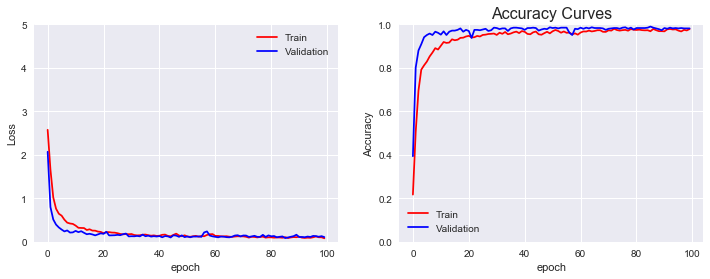

In [126]:
plot_results(cnn_hist_type, batch_size_type)

Testing the model on unseen testing data. Also, evaluating using more precisie metrices value of each class. 

50/50 [==============================] - 1s 17ms/step
                  precision    recall  f1-score   support

      rightofway       0.95      1.00      0.97        57
            stop       1.00      0.95      0.97        40
         bicycle       1.00      1.00      1.00        19
  limitedtraffic       1.00      0.98      0.99        46
         noentry       1.00      1.00      1.00        24
       noparking       0.89      0.96      0.92        25
      roundabout       1.00      0.96      0.98        75
           speed       0.96      0.92      0.94        48
trafficdirective       0.95      1.00      0.97        55
 traveldirection       1.00      1.00      1.00        56
        continue       1.00      1.00      1.00        20
        crossing       1.00      0.98      0.99        63
         laneend       1.00      1.00      1.00         9
         parking       1.00      1.00      1.00        39
         giveway       1.00      0.92      0.96        25
         warning 

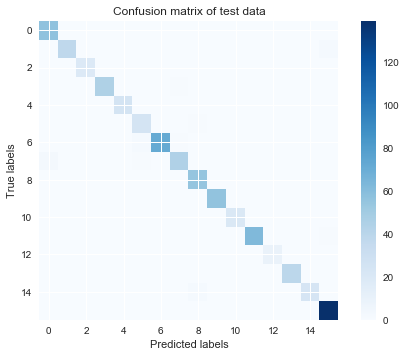

In [136]:
CNN_test_generator_type.reset()             
N_test_images = test_df_type.shape[0]
type_pred = cnn_model_type.predict_generator(CNN_test_generator_type,verbose=1,steps=N_test_images/15)
type_pred_labels = np.argmax(type_pred,axis=1)
cfm_type= confusion_matrix(CNN_test_generator_type.classes,type_pred_labels)
cm_type = classification_report(CNN_test_generator_type.classes,type_pred_labels, target_names=target_names_type)
print(cm_type)
plotCm(cfm_type)

Create model and fit it on ImageGenerator Data of augmented images in batches. Augmentation helps in reducing overfitting of training data.

In [137]:
#Create model
cnn_model_aug_type = cnn_create_model(output_class=type_classes, learning_rate=bt_lr, momentum_param=bt_momentum, 
                                 n1= bt_n1, n2 = bt_n2, n3=bt_n3, n4 = bt_n4)

# Calling function to fit CNN model on ImageGenerator Data of augmented images in batches
cnn_hist_aug_type, rescnn_model_aug_type = model_fitting(cnn_model_type, batch_size_type, n_epochs= bt_epoch,
                                    train_generator_data=CNN_aug_train_generator_type,
                                    validation_generator_data=CNN_validation_generator_type, no_train_images=N_train_images,
                                    no_val_images=N_val_images, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_202 (Activation)  (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_203 (Activation)  (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 3, 3, 64)          36928     
__________

158/158 [==============================] - 12s 79ms/step - loss: 0.9011 - categorical_accuracy: 0.7820 - acc: 0.7820 - f1_m: 0.7834 - precision_m: 0.8804 - recall_m: 0.7117 - val_loss: 0.2932 - val_categorical_accuracy: 0.9510 - val_acc: 0.9510 - val_f1_m: 0.9531 - val_precision_m: 0.9658 - val_recall_m: 0.9417
Epoch 13/100
158/158 [==============================] - 12s 73ms/step - loss: 0.8803 - categorical_accuracy: 0.7803 - acc: 0.7803 - f1_m: 0.7803 - precision_m: 0.8715 - recall_m: 0.7115 - val_loss: 0.2991 - val_categorical_accuracy: 0.9510 - val_acc: 0.9510 - val_f1_m: 0.9521 - val_precision_m: 0.9564 - val_recall_m: 0.9481
Epoch 14/100
158/158 [==============================] - 12s 79ms/step - loss: 0.8747 - categorical_accuracy: 0.7892 - acc: 0.7892 - f1_m: 0.7959 - precision_m: 0.8822 - recall_m: 0.7296 - val_loss: 0.3204 - val_categorical_accuracy: 0.9476 - val_acc: 0.9476 - val_f1_m: 0.9536 - val_precision_m: 0.9611 - val_recall_m: 0.9467
Epoch 15/100
158/158 [=============

158/158 [==============================] - 12s 73ms/step - loss: 0.5934 - categorical_accuracy: 0.8661 - acc: 0.8661 - f1_m: 0.8726 - precision_m: 0.9251 - recall_m: 0.8289 - val_loss: 0.2423 - val_categorical_accuracy: 0.9662 - val_acc: 0.9662 - val_f1_m: 0.9679 - val_precision_m: 0.9748 - val_recall_m: 0.9614
Epoch 29/100
158/158 [==============================] - 11s 68ms/step - loss: 0.7072 - categorical_accuracy: 0.8530 - acc: 0.8530 - f1_m: 0.8562 - precision_m: 0.9162 - recall_m: 0.8082 - val_loss: 0.2826 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9720 - val_precision_m: 0.9781 - val_recall_m: 0.9664
Epoch 30/100
158/158 [==============================] - 11s 72ms/step - loss: 0.5996 - categorical_accuracy: 0.8737 - acc: 0.8737 - f1_m: 0.8768 - precision_m: 0.9281 - recall_m: 0.8338 - val_loss: 0.2565 - val_categorical_accuracy: 0.9713 - val_acc: 0.9713 - val_f1_m: 0.9744 - val_precision_m: 0.9831 - val_recall_m: 0.9664
Epoch 31/100
158/158 [=============

Epoch 44/100
158/158 [==============================] - 12s 76ms/step - loss: 0.6380 - categorical_accuracy: 0.8695 - acc: 0.8695 - f1_m: 0.8749 - precision_m: 0.9300 - recall_m: 0.8293 - val_loss: 0.2222 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9804 - val_precision_m: 0.9848 - val_recall_m: 0.9767
Epoch 45/100
158/158 [==============================] - 12s 75ms/step - loss: 0.6086 - categorical_accuracy: 0.8728 - acc: 0.8728 - f1_m: 0.8801 - precision_m: 0.9326 - recall_m: 0.8366 - val_loss: 0.3152 - val_categorical_accuracy: 0.9595 - val_acc: 0.9595 - val_f1_m: 0.9617 - val_precision_m: 0.9708 - val_recall_m: 0.9533
Epoch 46/100
158/158 [==============================] - 12s 79ms/step - loss: 0.6535 - categorical_accuracy: 0.8580 - acc: 0.8580 - f1_m: 0.8632 - precision_m: 0.9111 - recall_m: 0.8233 - val_loss: 0.2384 - val_categorical_accuracy: 0.9814 - val_acc: 0.9814 - val_f1_m: 0.9814 - val_precision_m: 0.9864 - val_recall_m: 0.9767
Epoch 47/100
158/158 [

158/158 [==============================] - 12s 78ms/step - loss: 0.5494 - categorical_accuracy: 0.8914 - acc: 0.8914 - f1_m: 0.8912 - precision_m: 0.9376 - recall_m: 0.8521 - val_loss: 0.2374 - val_categorical_accuracy: 0.9797 - val_acc: 0.9797 - val_f1_m: 0.9799 - val_precision_m: 0.9817 - val_recall_m: 0.9783
Epoch 61/100
158/158 [==============================] - 12s 73ms/step - loss: 0.6297 - categorical_accuracy: 0.8783 - acc: 0.8783 - f1_m: 0.8784 - precision_m: 0.9215 - recall_m: 0.8417 - val_loss: 0.2483 - val_categorical_accuracy: 0.9747 - val_acc: 0.9747 - val_f1_m: 0.9713 - val_precision_m: 0.9746 - val_recall_m: 0.9681
Epoch 62/100
158/158 [==============================] - 11s 73ms/step - loss: 0.5545 - categorical_accuracy: 0.8973 - acc: 0.8973 - f1_m: 0.8927 - precision_m: 0.9367 - recall_m: 0.8551 - val_loss: 0.2510 - val_categorical_accuracy: 0.9764 - val_acc: 0.9764 - val_f1_m: 0.9764 - val_precision_m: 0.9781 - val_recall_m: 0.9748
Epoch 63/100
158/158 [=============

158/158 [==============================] - 12s 76ms/step - loss: 0.5791 - categorical_accuracy: 0.8872 - acc: 0.8872 - f1_m: 0.8907 - precision_m: 0.9299 - recall_m: 0.8569 - val_loss: 0.2757 - val_categorical_accuracy: 0.9713 - val_acc: 0.9713 - val_f1_m: 0.9715 - val_precision_m: 0.9733 - val_recall_m: 0.9700
Epoch 77/100
158/158 [==============================] - 12s 76ms/step - loss: 0.5978 - categorical_accuracy: 0.8813 - acc: 0.8813 - f1_m: 0.8896 - precision_m: 0.9373 - recall_m: 0.8498 - val_loss: 0.2736 - val_categorical_accuracy: 0.9662 - val_acc: 0.9662 - val_f1_m: 0.9706 - val_precision_m: 0.9749 - val_recall_m: 0.9667
Epoch 78/100
158/158 [==============================] - 12s 76ms/step - loss: 0.5214 - categorical_accuracy: 0.9011 - acc: 0.9011 - f1_m: 0.9037 - precision_m: 0.9462 - recall_m: 0.8675 - val_loss: 0.2127 - val_categorical_accuracy: 0.9865 - val_acc: 0.9865 - val_f1_m: 0.9866 - val_precision_m: 0.9883 - val_recall_m: 0.9850
Epoch 79/100
158/158 [=============

Epoch 92/100
158/158 [==============================] - 12s 74ms/step - loss: 0.5412 - categorical_accuracy: 0.9011 - acc: 0.9011 - f1_m: 0.9031 - precision_m: 0.9409 - recall_m: 0.8709 - val_loss: 0.3044 - val_categorical_accuracy: 0.9679 - val_acc: 0.9679 - val_f1_m: 0.9689 - val_precision_m: 0.9748 - val_recall_m: 0.9633
Epoch 93/100
158/158 [==============================] - 11s 69ms/step - loss: 0.5766 - categorical_accuracy: 0.8893 - acc: 0.8893 - f1_m: 0.8945 - precision_m: 0.9376 - recall_m: 0.8580 - val_loss: 0.2483 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9740 - val_precision_m: 0.9765 - val_recall_m: 0.9717
Epoch 94/100
158/158 [==============================] - 11s 71ms/step - loss: 0.5971 - categorical_accuracy: 0.8876 - acc: 0.8876 - f1_m: 0.8861 - precision_m: 0.9295 - recall_m: 0.8492 - val_loss: 0.2694 - val_categorical_accuracy: 0.9730 - val_acc: 0.9730 - val_f1_m: 0.9766 - val_precision_m: 0.9800 - val_recall_m: 0.9733
Epoch 95/100
158/158 [

Visualing the result

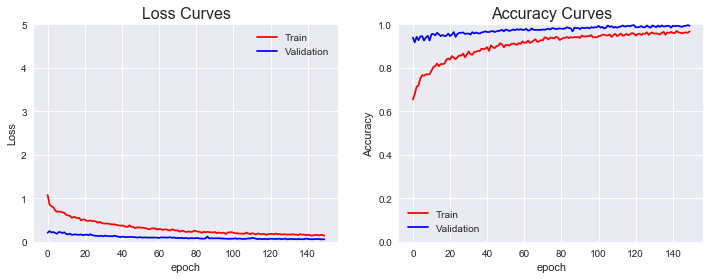

In [173]:
plot_results(cnn_hist_aug_shape, 60)

Testing model on unseen test data. Checking class wise evaluation

50/50 [==============================] - 1s 12ms/step
                  precision    recall  f1-score   support

      rightofway       0.96      0.96      0.96        57
            stop       1.00      1.00      1.00        40
         bicycle       0.95      1.00      0.97        19
  limitedtraffic       1.00      1.00      1.00        46
         noentry       0.92      1.00      0.96        24
       noparking       1.00      0.88      0.94        25
      roundabout       0.97      0.96      0.97        75
           speed       0.96      0.94      0.95        48
trafficdirective       1.00      0.98      0.99        55
 traveldirection       1.00      1.00      1.00        56
        continue       1.00      1.00      1.00        20
        crossing       1.00      1.00      1.00        63
         laneend       1.00      1.00      1.00         9
         parking       0.95      0.97      0.96        39
         giveway       0.96      1.00      0.98        25
         warning 

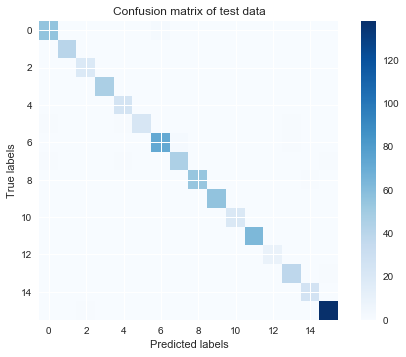

In [141]:
CNN_test_generator_type.reset()             
N_test_images = test_df_type.shape[0]
type_pred_aug = rescnn_model_aug_type.predict_generator(CNN_test_generator_type,verbose=1,steps=N_test_images/batch_size_type)
type_pred_labels_aug = np.argmax(type_pred_aug,axis=1)
cfm_type_aug= confusion_matrix(CNN_test_generator_type.classes,type_pred_labels_aug)
cm_type_aug = classification_report(CNN_test_generator_type.classes,type_pred_labels_aug, target_names=target_names_type)
print(cm_type_aug)
plotCm(cfm_type_aug)

## Independent Evaluation

I have gathered data from various countries and tried to manually map it according to original dataset.

Loading the data

In [146]:
data_list = []

for filepath in glob.glob('./EvalData/Evaluation Data/*/*/*/*.png', recursive=True): #assuming gif
    signtype = filepath.split("\\")[-2]
    shape = filepath.split("\\")[-3]
    country = filepath.split("\\")[-4]
    data_list.append((filepath, signtype, shape, country))
    
# Create a data frame
eval_data = pd.DataFrame(data=data_list, columns=['image_path', 'signtype', 'shape', 'country'])

# Mapping lables to shape and type
eval_data['shape_labels_num'] = eval_data['shape'].map(mapshape, na_action='ignore')
eval_data['type_labels_num'] = eval_data['signtype'].map(maptype, na_action='ignore')

eval_data.head()

,image_path,signtype,shape,country,shape_labels_num,type_labels_num
0,./EvalData/Evaluation Data\Australia\diamond\a...,all,diamond,Australia,0,NaN
1,./EvalData/Evaluation Data\Australia\diamond\a...,all,diamond,Australia,0,NaN
2,./EvalData/Evaluation Data\Australia\diamond\a...,all,diamond,Australia,0,NaN
3,./EvalData/Evaluation Data\Australia\diamond\a...,all,diamond,Australia,0,NaN
4,./EvalData/Evaluation Data\Australia\diamond\a...,all,diamond,Australia,0,NaN


In [147]:
eval_shape = eval_data.drop(eval_data.columns[[1,5]], axis=1)
eval_type = eval_data.drop(eval_data.columns[[2,4]], axis=1)
eval_shape.head()

,image_path,shape,country,shape_labels_num
0,./EvalData/Evaluation Data\Australia\diamond\a...,diamond,Australia,0
1,./EvalData/Evaluation Data\Australia\diamond\a...,diamond,Australia,0
2,./EvalData/Evaluation Data\Australia\diamond\a...,diamond,Australia,0
3,./EvalData/Evaluation Data\Australia\diamond\a...,diamond,Australia,0
4,./EvalData/Evaluation Data\Australia\diamond\a...,diamond,Australia,0


In [149]:
eval_type = (eval_type.loc[eval_type['signtype'] != 'all'])
eval_type.head()

,image_path,signtype,country,type_labels_num
18,./EvalData/Evaluation Data\Germany\hex\stop\00...,stop,Germany,1.0
19,./EvalData/Evaluation Data\Germany\hex\stop\00...,stop,Germany,1.0
20,./EvalData/Evaluation Data\Germany\hex\stop\00...,stop,Germany,1.0
21,./EvalData/Evaluation Data\Germany\hex\stop\00...,stop,Germany,1.0
22,./EvalData/Evaluation Data\Germany\hex\stop\00...,stop,Germany,1.0


In [163]:
image_list_shape_eval, X_shape_eval = readImages(eval_shape.iloc[:,0])
target_shape_eval = eval_shape.iloc[:,3]

image_list_type_eval, X_type_eval = readImages(eval_type.iloc[:,0])
target_type_eval = eval_type.iloc[:,3]

In [158]:
CNN_eval_generator_shape = CNN_val_datagen.flow_from_dataframe(
        dataframe=eval_shape,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical',
        shuffle = False)

CNN_eval_generator_type = CNN_val_datagen.flow_from_dataframe(
        dataframe=eval_type,
        directory='./',
        x_col="image_path",
        y_col="signtype",
        target_size=(28, 28),
        batch_size=batch_size_type,
        class_mode='categorical',
        shuffle = False)

N_eval_images_type = eval_type.shape[0]
N_eval_images_shape = eval_shape.shape[0]

Found 126 validated image filenames belonging to 5 classes.
Found 108 validated image filenames belonging to 10 classes.


Evaluating on type model with independent data

Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  1  0 23  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0 10  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  4  0  0  0  1  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  1  0  0]
 [ 1  8  0  0  0  0  0  1  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9]]
Classification Report
                  precision    recall  f1-score   support

            stop       0.00      0.00      0.00         0
         bicycle       0.00      0.00      0.00        33
  limitedtraffic       0.00      0.00      0.00         2
       

C:\Users\Vishwa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Vishwa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


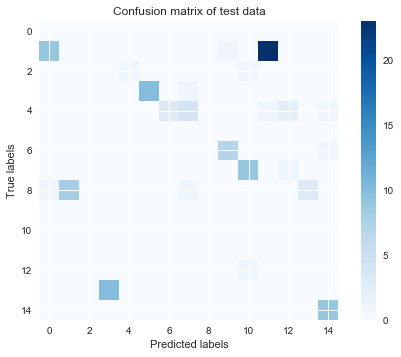

In [185]:
ttarget_names_type = [ 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking',
           'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue',
           'crossing', 'laneend', 'parking', 'giveway', 'warning']



calConfusionMatrix(rescnn_model_aug_type, X_type_eval, target_type_eval, ttarget_names_type)


Evaluating performance on  shape model.

9/9 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00         6
         hex       1.00      0.75      0.86        36
       round       0.80      0.95      0.87        59
      square       0.00      0.00      0.00         4
    triangle       0.70      0.90      0.79        21

   micro avg       0.81      0.81      0.81       126
   macro avg       0.50      0.52      0.50       126
weighted avg       0.78      0.81      0.78       126



C:\Users\Vishwa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


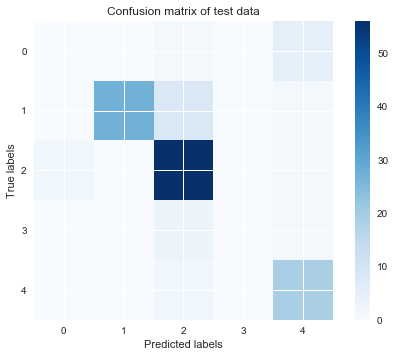

In [162]:
CNN_eval_generator_shape.reset() 
N_test_images = test_df_type.shape[0]

shape_pred_eval = rescnn_model_aug_shape.predict_generator(CNN_eval_generator_shape,verbose=1,
                                                           steps=N_eval_images_shape/batch_size_shape)
shape_pred_labels_eval = np.argmax(shape_pred_eval,axis=1)
cfm_shape_eval= confusion_matrix(CNN_eval_generator_shape.classes,shape_pred_labels_eval)
cm_shape_eval = classification_report(CNN_eval_generator_shape.classes,shape_pred_labels_eval, target_names=target_names_shape)
print(cm_shape_eval)
plotCm(cfm_shape_eval)